# Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
Критерии, которые важны заказчику:
качество предсказания;
время обучения модели;
время предсказания модели.

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

# Бейзлайн

## Импорты

In [1]:
!pip install lightgbm -q
!pip install catboost -q
!pip install xgboost -q
!pip install phik -q
!pip install aiohttp -q
!pip install nest_asyncio -q
!pip install tqdm -q

In [2]:
# базовые библиотеки
import os
import asyncio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# асинхронные библиотеки
import aiohttp
from tqdm.asyncio import tqdm_asyncio
import nest_asyncio

# корреляции
import phik

# sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

# модели
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
import xgboost as xgb

# константы
TEST_SIZE = 0.2
RANDOM_STATE = 42

## Загрузка данных

In [3]:
try:
    df = pd.read_csv('D:/dev/study/practicum/17. Численные методы/practice/autos.csv')
    print('Local load')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
    print('Online load')
    
df.head(10)

Данные загружены успешно, в данных присутсвуют разные типы данных и пропуски.

In [4]:
df.info()

In [5]:
df.describe()

In [6]:
df.isna().sum()[df.isna().sum() > 0]

В данных достаточно много пропусков и неправильных типов данных, а также, вероятно, много неактуальных данных (старая выгрузка). Предобработаем их и проведем анализ каждого поля.

## Предобработка данных + EDA

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analize_feature(column, title=None):
    if title is None:
        title = column

    print(f'Анализ {column}:')
    print(f'Количество пропусков: {df[column].isna().sum()}')
    print(f'Количество уникальных значений: {df[column].nunique()}')
    print(df[column].describe())

    plt.figure(figsize=(16, 6))
    plt.suptitle(title, fontsize=16)

    nunique = df[column].nunique()
    dtype = df[column].dtype

    if pd.api.types.is_datetime64_any_dtype(dtype):
        plt.subplot(1, 1, 1)
        df[column].value_counts().sort_index().plot()
        plt.title('Распределение по времени')
        plt.xlabel(title)
        plt.ylabel('Частота')
        plt.xticks(rotation=45)

    elif nunique < 20:
        plt.subplot(1, 1, 1)
        order = df[column].value_counts().index
        sns.countplot(data=df, x=column, order=order, color='gold', alpha=0.7, edgecolor='black')
        plt.title('Количество уникальных значений')
        plt.xlabel(title)
        plt.ylabel('Частота')
        plt.xticks(rotation=45)

    elif pd.api.types.is_numeric_dtype(dtype):
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], bins=50, color='green', alpha=0.5, edgecolor='black', kde=True)
        plt.title('Гистограмма с графиком плотности')
        plt.xlabel(title)
        plt.ylabel('Частота')

        plt.subplot(1, 2, 2)
        plt.boxplot(df[column].dropna(), vert=True, patch_artist=True,
                    boxprops=dict(facecolor='skyblue', color='black'),
                    medianprops=dict(color='black'))
        plt.title('Ящик с усами')
        plt.ylabel(title)

    else:
        # категориальный столбец с большим числом уникальных значений
        top_vals = df[column].value_counts().nlargest(20)
        plt.subplot(1, 1, 1)
        sns.barplot(x=top_vals.values, y=top_vals.index, palette='magma')
        plt.title('Топ-20 значений по частоте')
        plt.xlabel('Частота')
        plt.ylabel(title)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [8]:
df.dtypes

### DateCrawled

In [9]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])

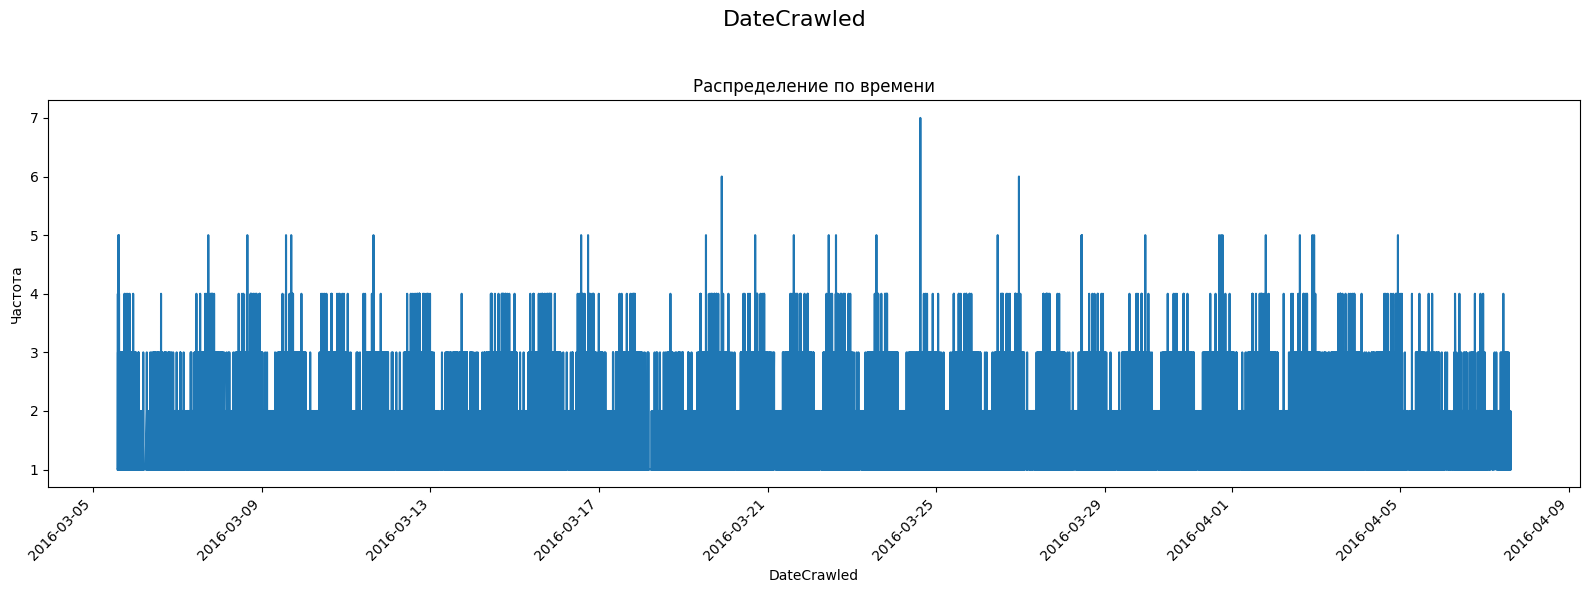

In [10]:
analize_feature('DateCrawled')

Такое количество уникальных значений не несет прогностической ценности. Эти данные только подтверждают то, что датасет был собран примерно в одном временном промежутке - с 2016-03-05 по 2016-04-07. Это хорошо, но признак можно удалить, либо заменить константой, что не даст никакого буста в качестве модели.

**Решение:** удалить.

In [11]:
df = df.drop(columns='DateCrawled')

### Price

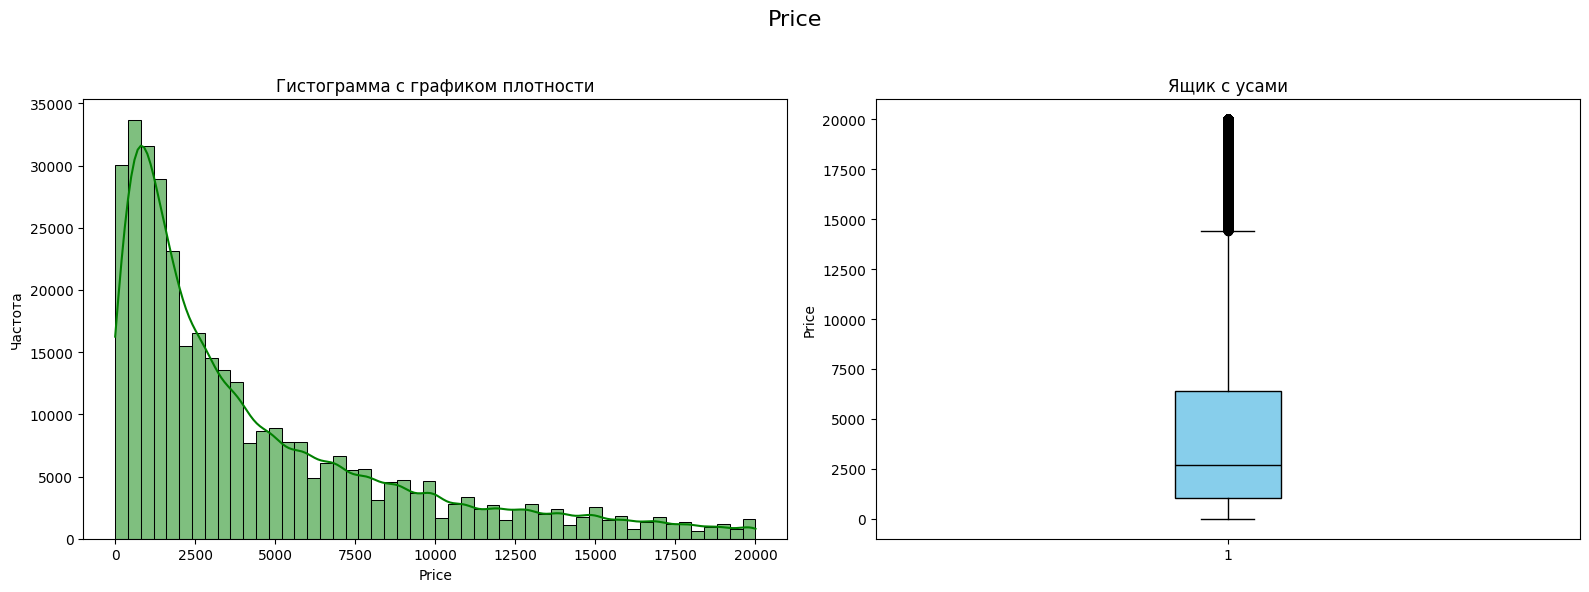

In [12]:
analize_feature('Price')

- Пропусков нет,
- Уникальных значений: 3731
- Минимальная цена: 0 евро (ошибка или выброс, проверим)
- Средняя цена: 4416 евро (допустимо)
- Максимальная цена: 20000 евро (допустимо, но если количество подобных экземпляров будет небольшим, данные стоит очистить от таких значений)

- Распределения нет, наблюдается нисходящий тренд (выше стоимость - меньше количество), почти прямая зависимость с некоторыми вплесками на определенных значениях.

Рассмотрим данные подробнее.

In [13]:
display(df.query('Price >= 0 and Price <= 300').head(), 
        f'Общее количество строк: {len(df.query("Price >= 0 and Price <= 300"))}')

- Авто за 0 евро оказалось около 10 тысяч строк.
- За 1 евро порядка 1200 строк.
- От 1 до 300 евро (что уже на грани адекватной цены за поддержанный автомобиль в европе на 2016 год) в данных еще около 15 тысяч строк.

**Решение:** удалить все строки со значеним цены от 0 до 300 евро (около 26 тысяч строк).

In [14]:
df = df.query('Price >= 300')

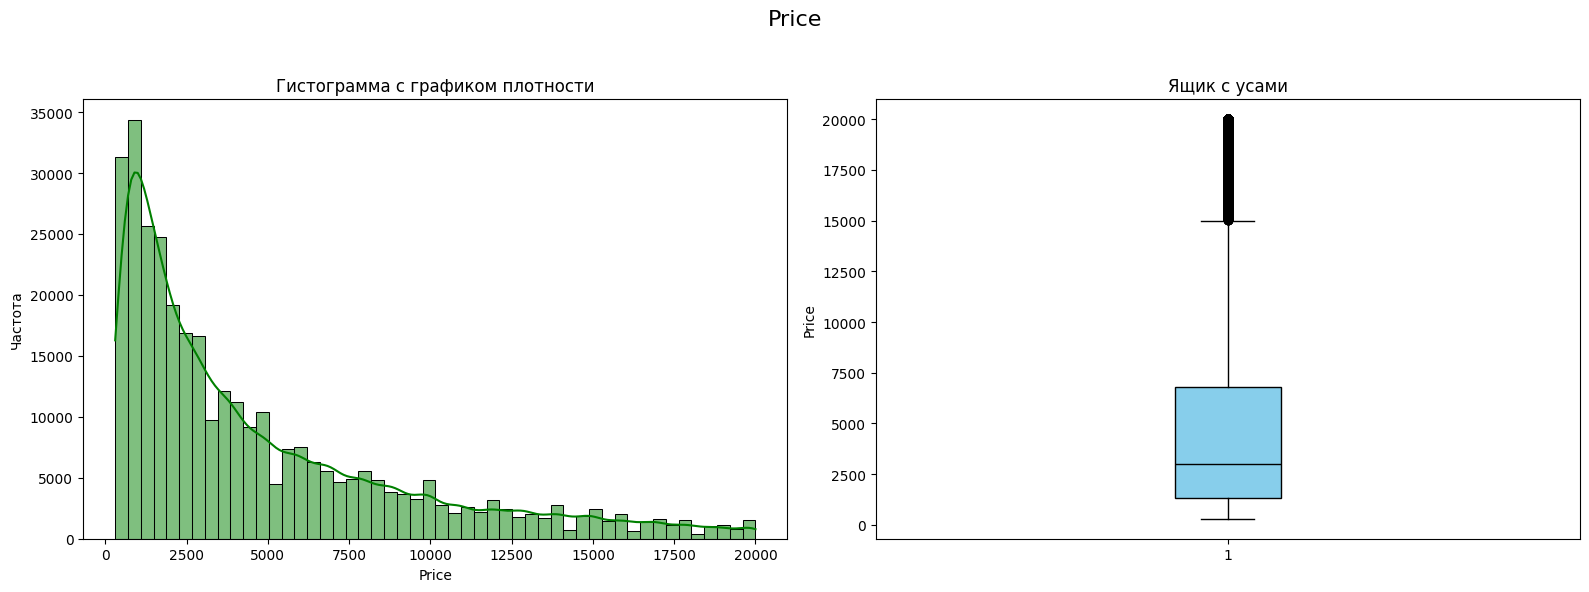

In [15]:
analize_feature('Price')

In [16]:
display(df.query('Price >= 15000').head(5), f"Общее количество строк: {len(df.query('Price >= 15000'))}")

- Автомобилей с ценой 20000 в данных порядка 250 штук, что маловато для нормального обучения модели, но достаточно для поиска различных связей.
- Данных с ценой выше 15000 тысяч евро около 15 тысяч строк, что в масштабах данных очень мало, но пока что трогать не будем, нужно посмотреть на результаты обучения моделей.

**Решение:** пока что не трогать.

### VehicleType

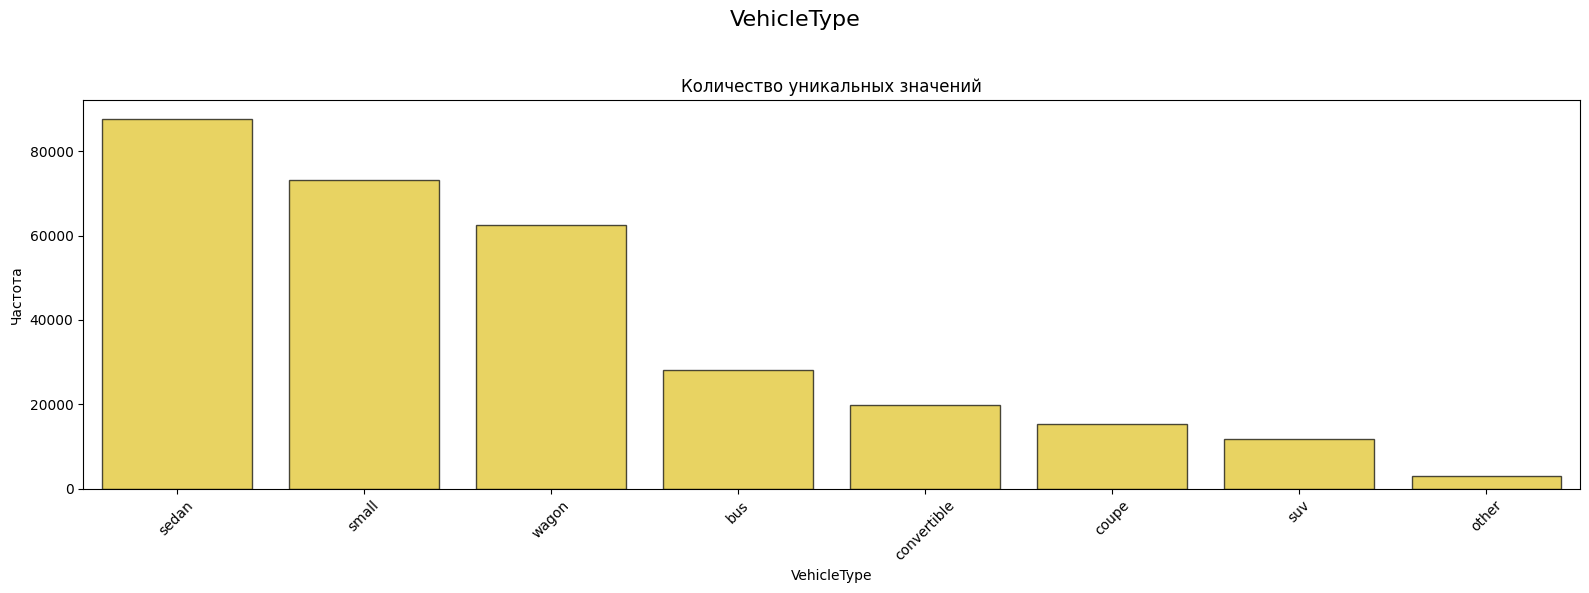

In [17]:
analize_feature('VehicleType')

In [18]:
display(df.query('VehicleType.isna()').head(5), f"Общее количество строк: {len(df.query('VehicleType.isna()'))}")

In [19]:
display(df.query('VehicleType.isna() and Model == "golf" and Brand == "volkswagen"').head(5), 
        "Общее количество строк: " + str(
            len(
                df.query('VehicleType.isna() and Model == "golf" and Brand == "volkswagen"')
            )))

По уникальным парам Brand и Model пропусков не так много, попробую заполнить их модой по этим уникальным парам из тех значений, где пропусков нет.

1. Если и Brand, и Model не нан, заполню по моде Brand + Model.
2. Если Model нан, но Brand есть, заполню по моде Brand.
3. Если Brand нан, но Model есть, заполняем по моде Model.
4. Иначе — заполняем модой по VehicleType.

In [20]:
def fill_missing_by_mode(df, target_col, *group_cols):
    '''
    1. принимает первым аргументом название столбца для заполнения (target_col);
    2. затем — любое количество столбцов, по которым группировать (например, Brand, Model);
    3. заполняет пропуски по иерархии мод: от самого точного сочетания до общей моды.
    '''
    global_mode = df[target_col].mode()[0]

    mode_dicts = []
    for i in range(len(group_cols), 0, -1):
        group = list(group_cols[:i])
        mode = (
            df[df[target_col].notna()]
            .groupby(group)[target_col]
            .agg(lambda x: x.mode()[0])
        )
        mode_dicts.append((group, mode))

    def fill_row(row):
        if pd.notna(row[target_col]):
            return row[target_col]
        for group, mode in mode_dicts:
            key_values = [row[col] for col in group]
            if all(pd.notna(key_values)):
                key = tuple(key_values) if len(key_values) > 1 else key_values[0]
                val = mode.get(key)
                if val is not None:
                    return val
        return global_mode

    df[target_col] = df.apply(fill_row, axis=1)
    return df

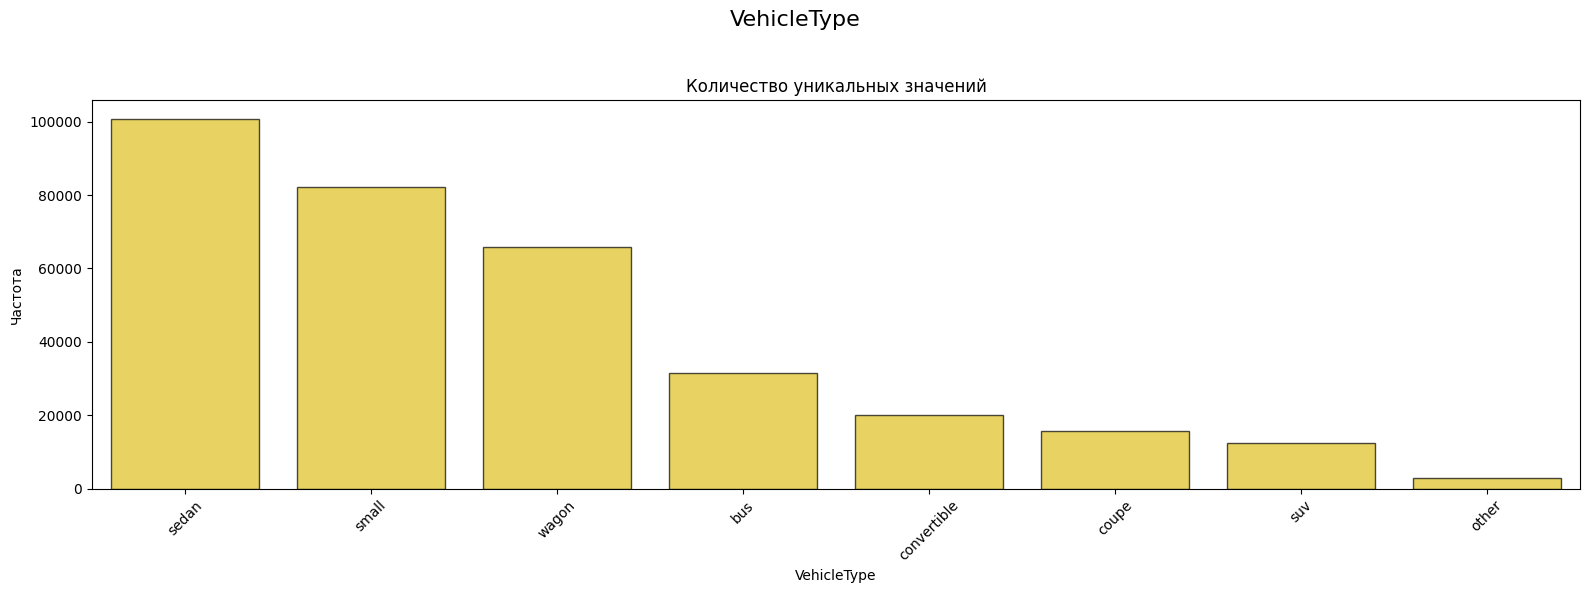

In [21]:
# применяем функцию
df = fill_missing_by_mode(df, 'VehicleType', 'Brand', 'Model')

analize_feature('VehicleType')

In [22]:
df['VehicleType'].value_counts()

Заполнилось около 25 тыс пропусков. Те, которые не заполнились, удалю.

In [23]:
# df = df.query('VehicleType != "other"')
# df['VehicleType'].value_counts()

<div class="alert alert-info"> <b>Комментарий двоечника:)</b>

    1. Благодарю, учту это в будущем!
    2. Почти 3 тысячи "другое"... ну даже не знаю, я не сильно вижу полезность этих данных.
</div> 

### RegistrationYear

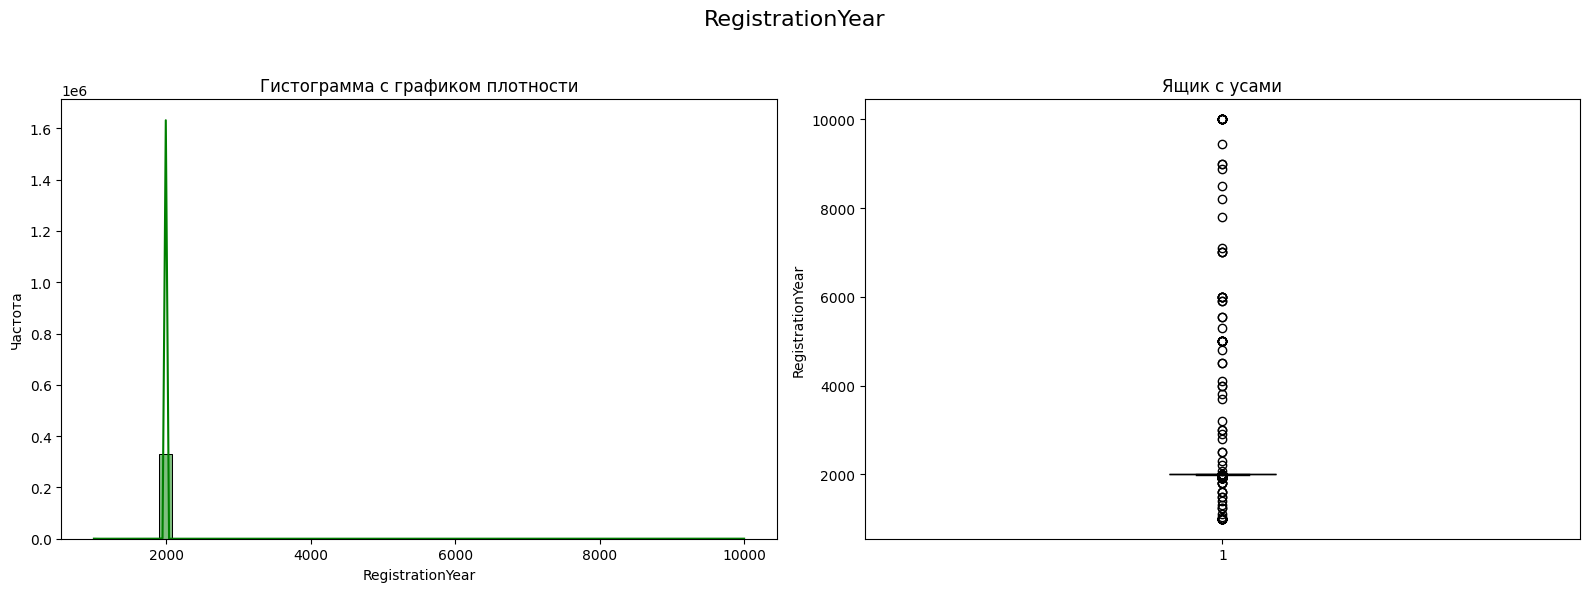

In [24]:
analize_feature('RegistrationYear')

Минимальное и максимальное значения - 1000 и 9999 гг.. Такого быть не может, поэтому очистим данные от 1965 по год выгрузки данных - 2016.

In [25]:
df = df.query('1965 <= RegistrationYear <= 2016')

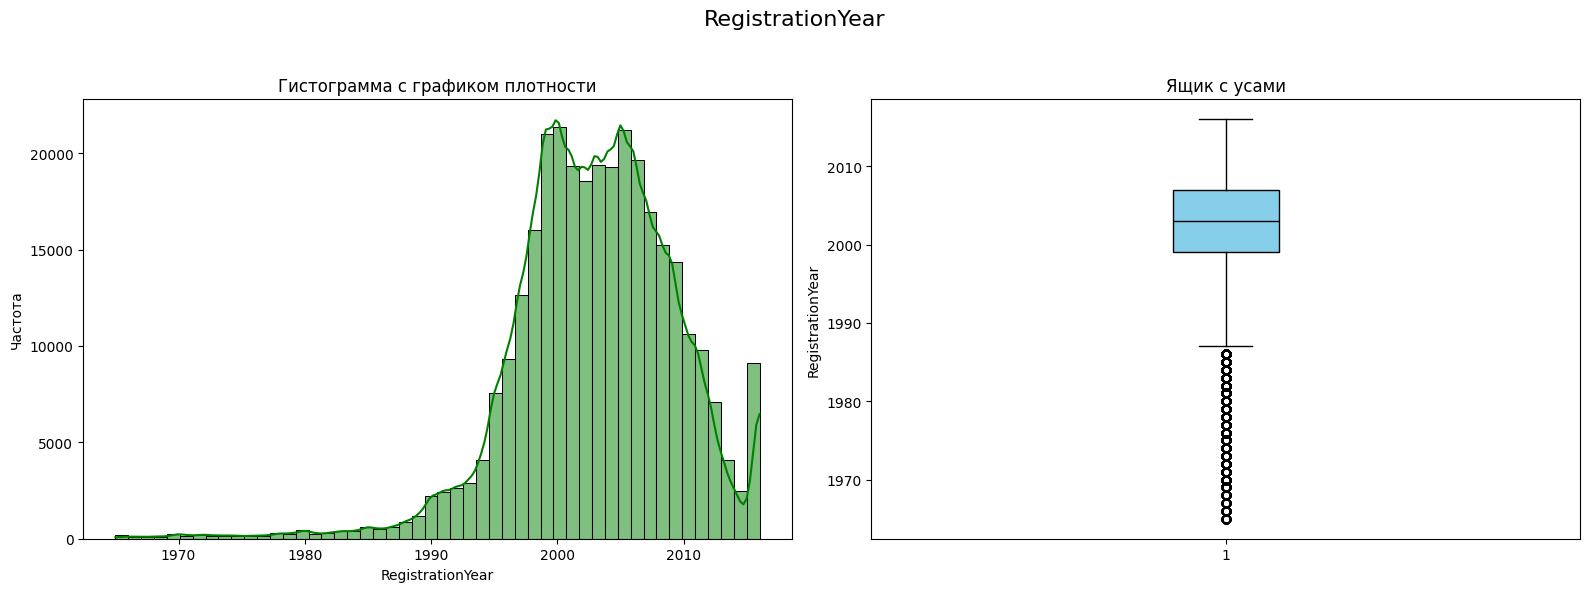

In [26]:
analize_feature('RegistrationYear')

Так лучше. Количество зарегистрированных авто до 1965 слишком мало, чтобы использовать их для обучения модели.

### Gearbox

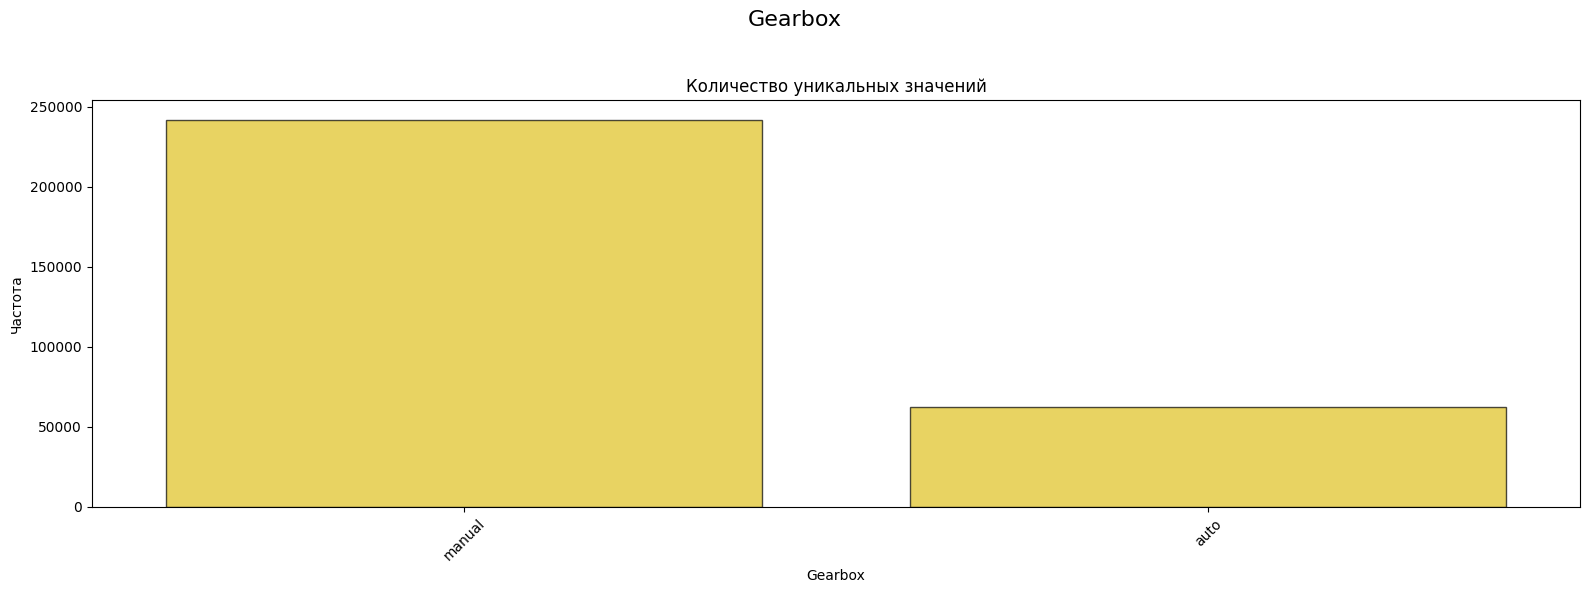

In [27]:
analize_feature('Gearbox')

В данных 12804 пропуска, заполню также модой.

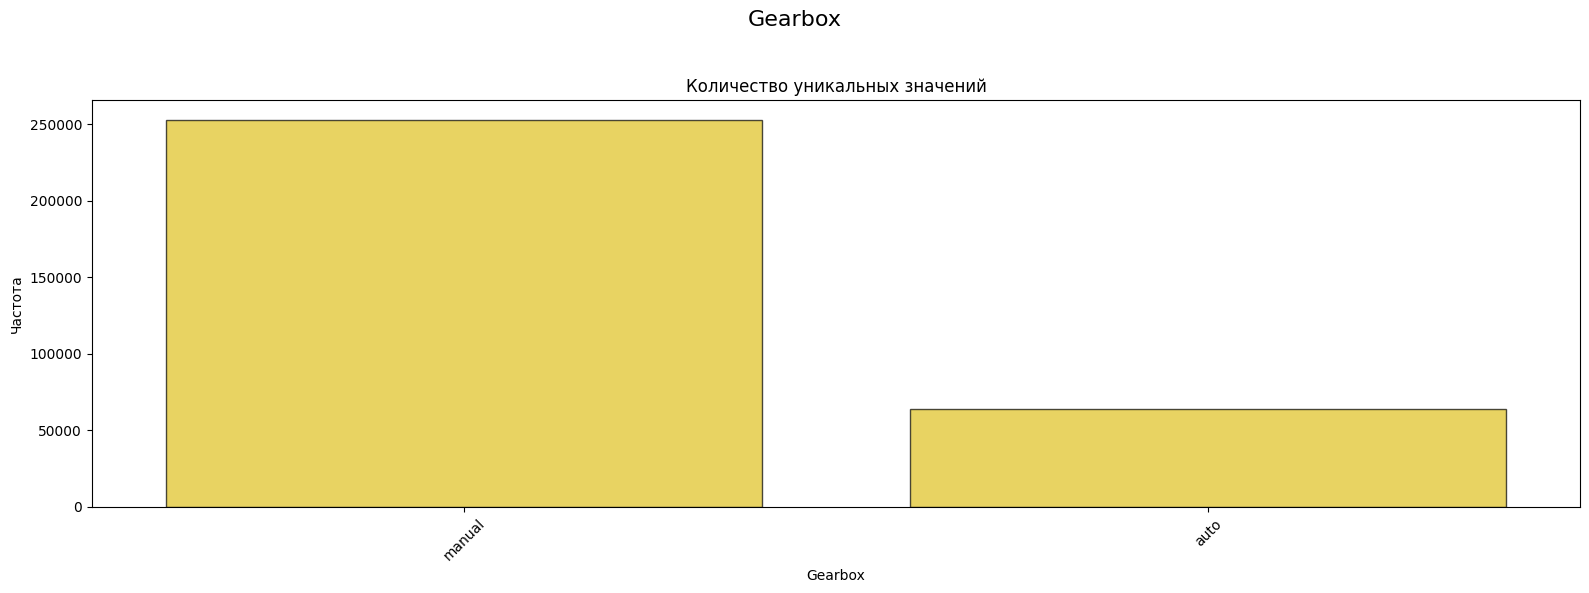

In [28]:
df = fill_missing_by_mode(df, 'Gearbox', 'Brand', 'Model', 'FuelType')

analize_feature('Gearbox')

Все значения заполнены.

### Power

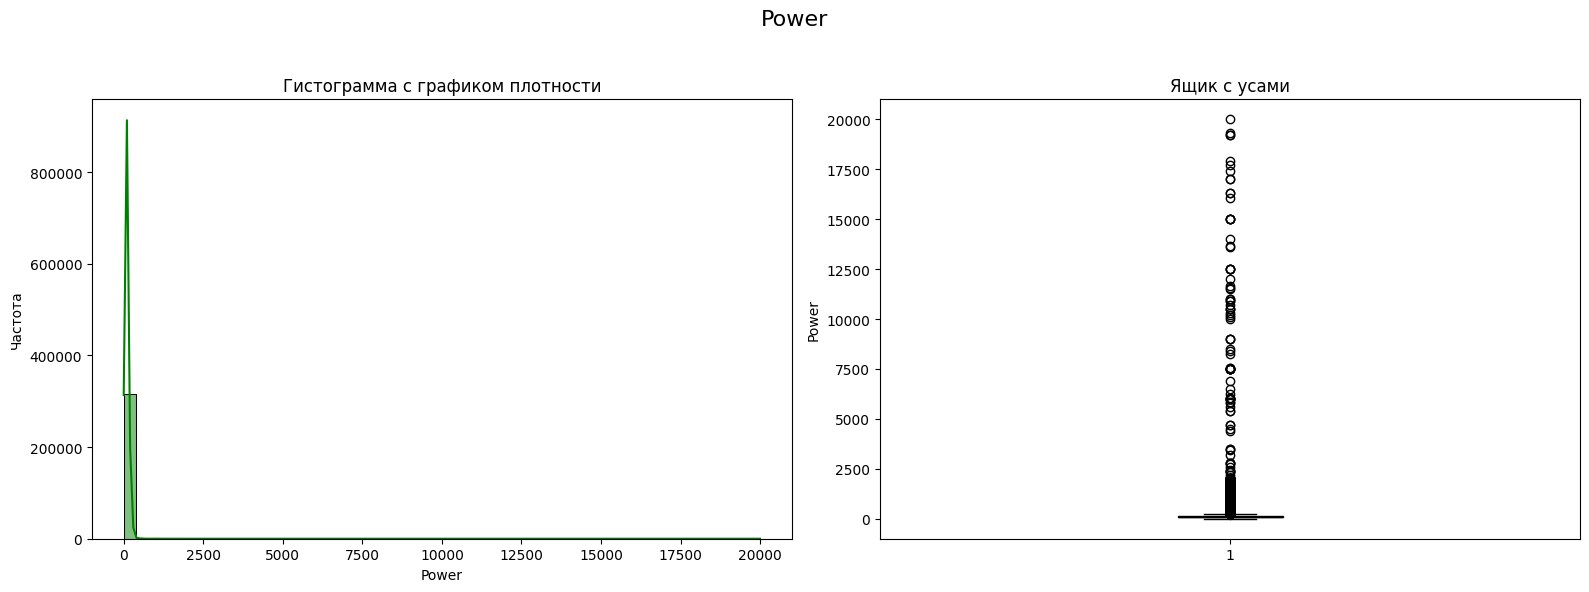

In [29]:
analize_feature('Power')

Мощность от 0 до 20000 л/с. Ни 0, ни 20000 невозможны, оставим значения от 45 л/с (Smart Car) до 400 л/с (BMW M5)

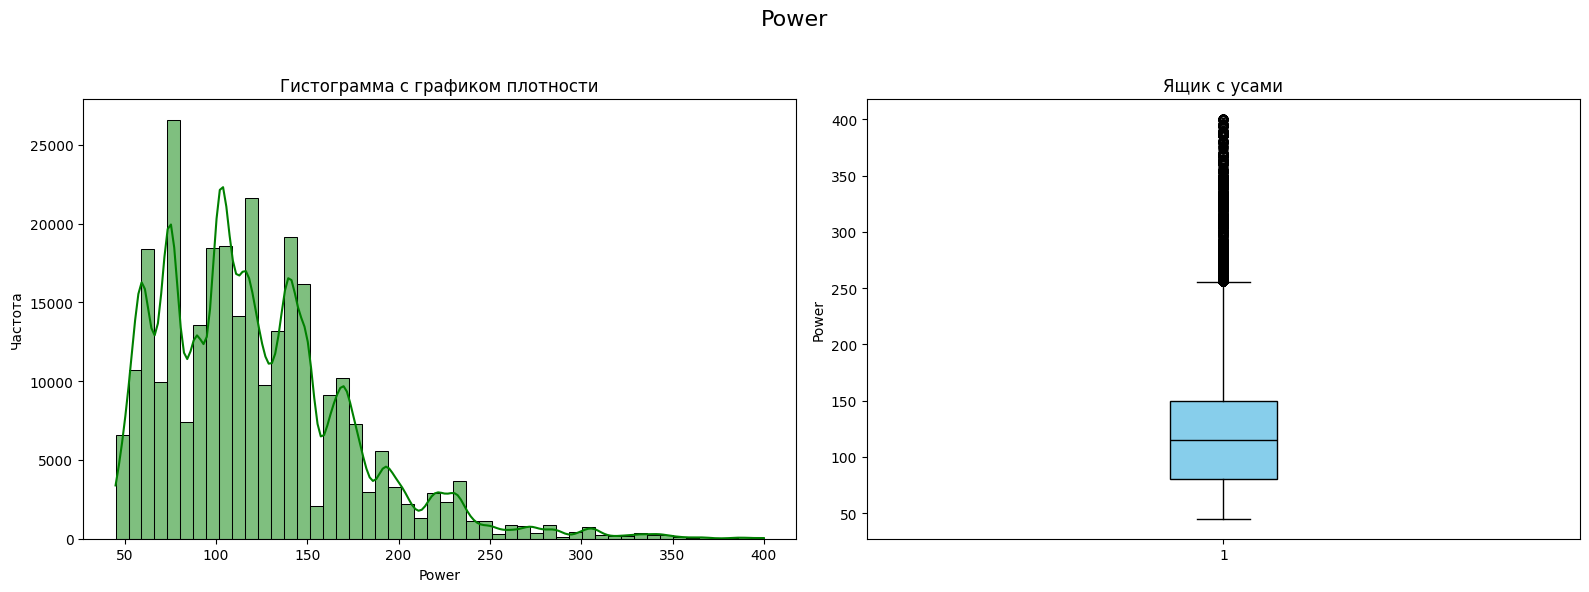

In [30]:
df = df.query('45 <= Power <= 400')

analize_feature('Power')

Датафрейм сократился на 30 тысяч строк.

### Model

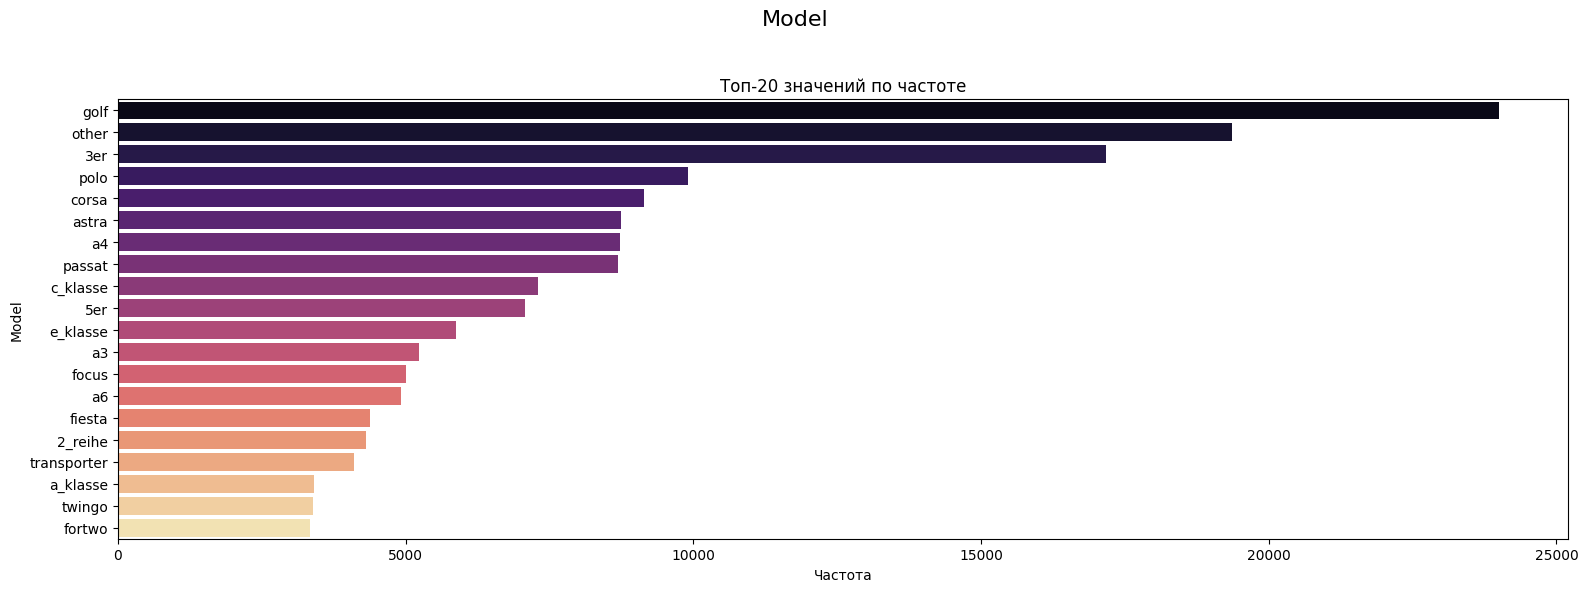

In [31]:
analize_feature('Model')

Самый популярный - Гольф. Вероятно, Вольксваген Гольф, поэтому снова заполним пропуски модой на основе других столбцов.

In [32]:
df = fill_missing_by_mode(df, 'Model', 'Brand', 'FuelType', 'Power', 'Gearbox')

df['Model'].value_counts()

In [33]:
df['Model'] = df['Model'].str.lower().str.replace('_', ' ', regex=False)

sorted(df['Model'].unique())

In [34]:
df.query('Model == "rangerover"')

In [35]:
df = df.query('Model != "rangerover"')

Неявных дубликатов нет.

### Kilometer

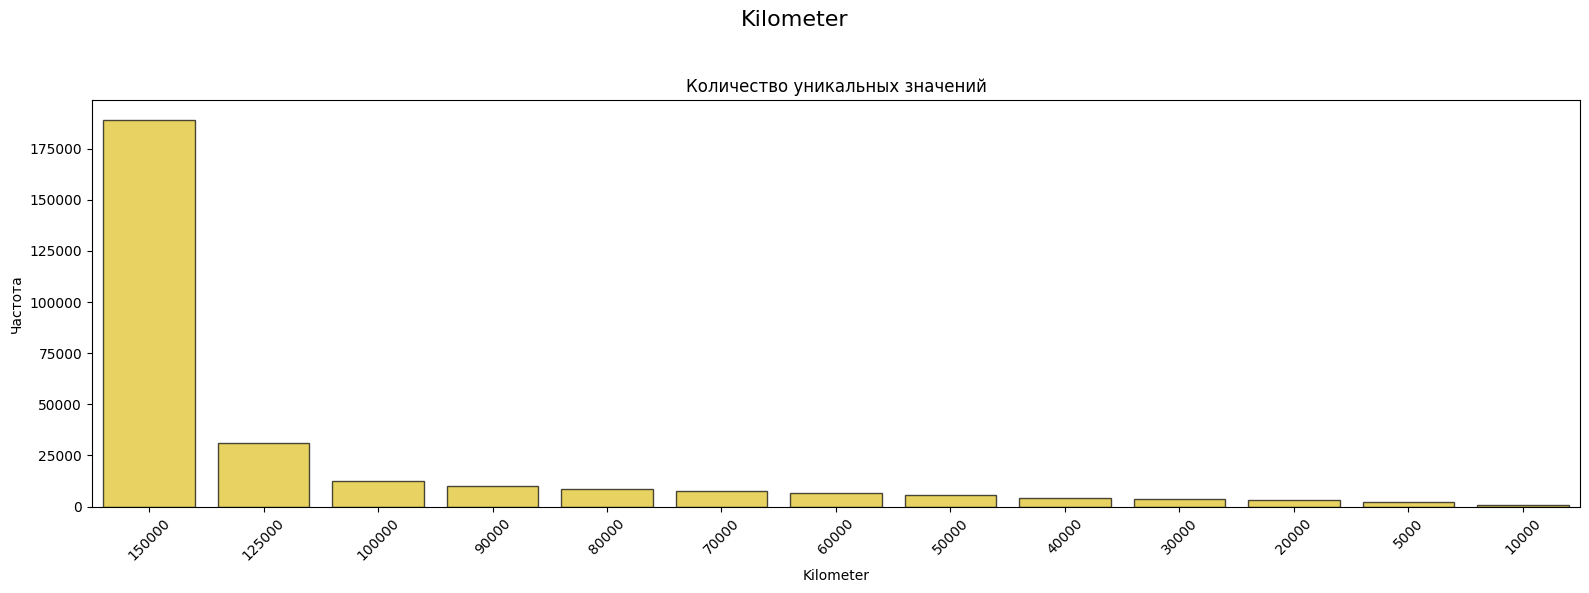

In [36]:
analize_feature('Kilometer')

Все значения и диапазоны похожи на правду.

### RegistrationMonth

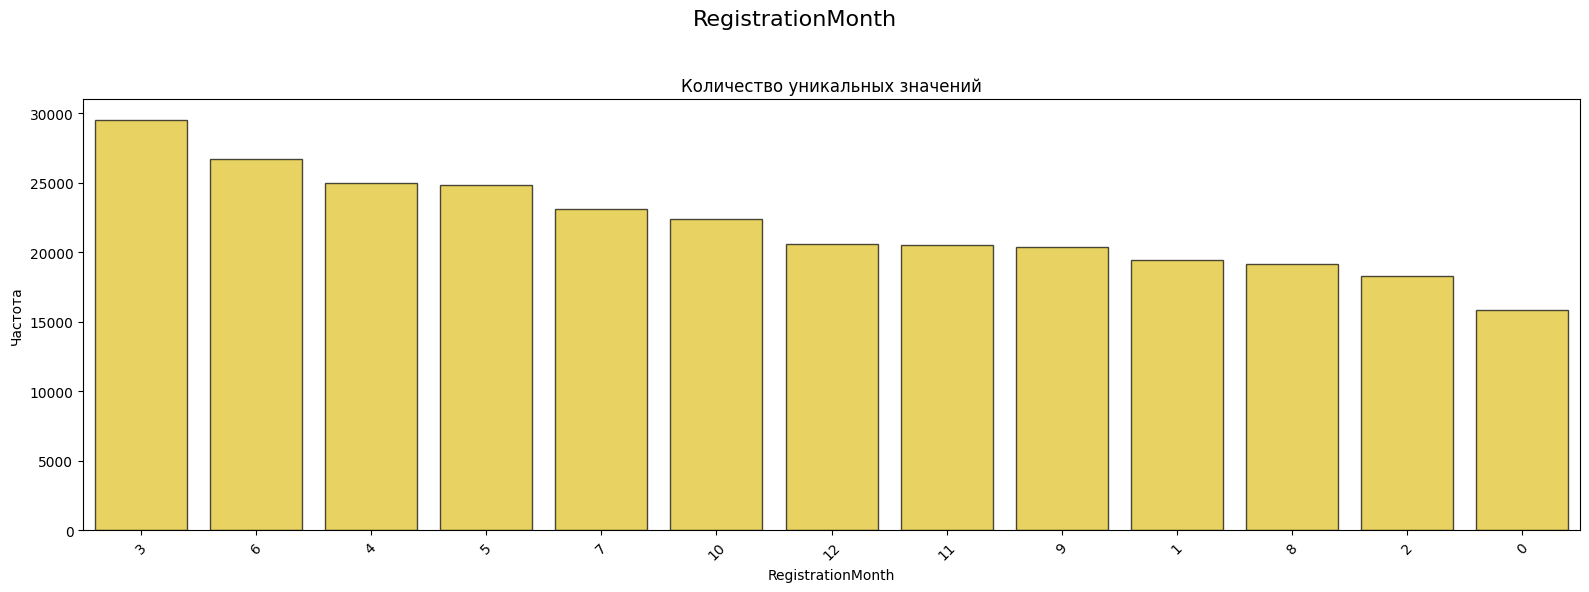

In [37]:
analize_feature('RegistrationMonth')

На нашей планете всего 12 месяцев, поэтому месяц со значением "0" удалю.

In [38]:
df = df.query('RegistrationMonth != 0')

### FuelType

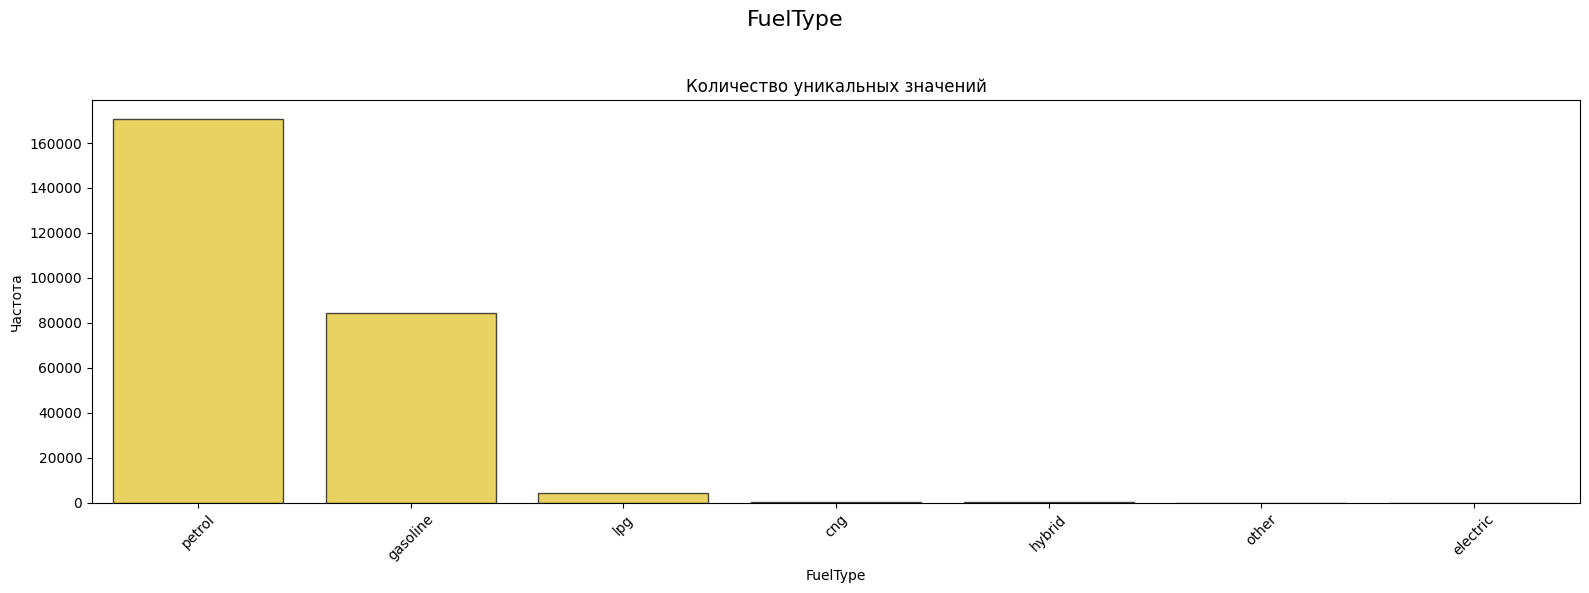

In [39]:
analize_feature('FuelType')

In [40]:
df['FuelType'].value_counts()

In [41]:
df = fill_missing_by_mode(df, 'FuelType', 'Model', 'Brand', 'Power', 'Gearbox')

In [42]:
df['FuelType'].value_counts()

Некоторых значений очень мало для модели, но пока что трогать не буду.

### Brand

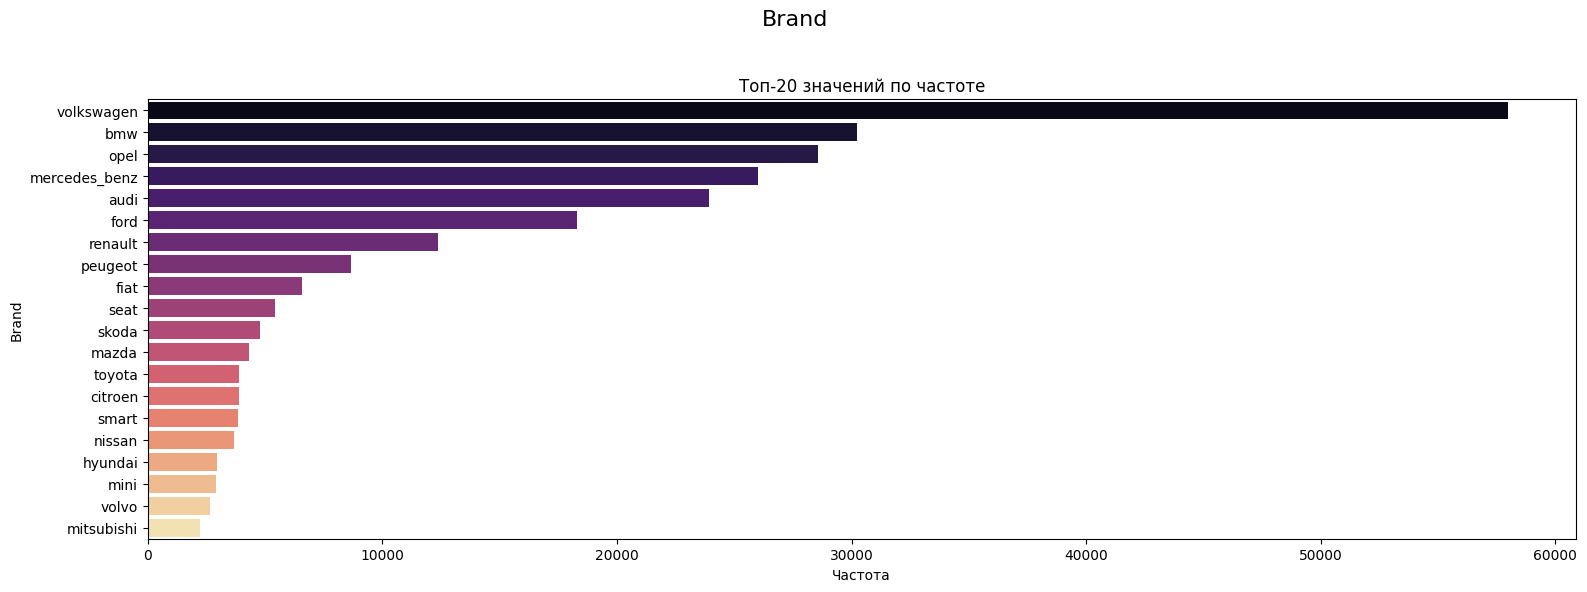

In [43]:
analize_feature('Brand')

In [44]:
sorted(df['Brand'].unique())

Неявных дубликатов нет.

### Repaired

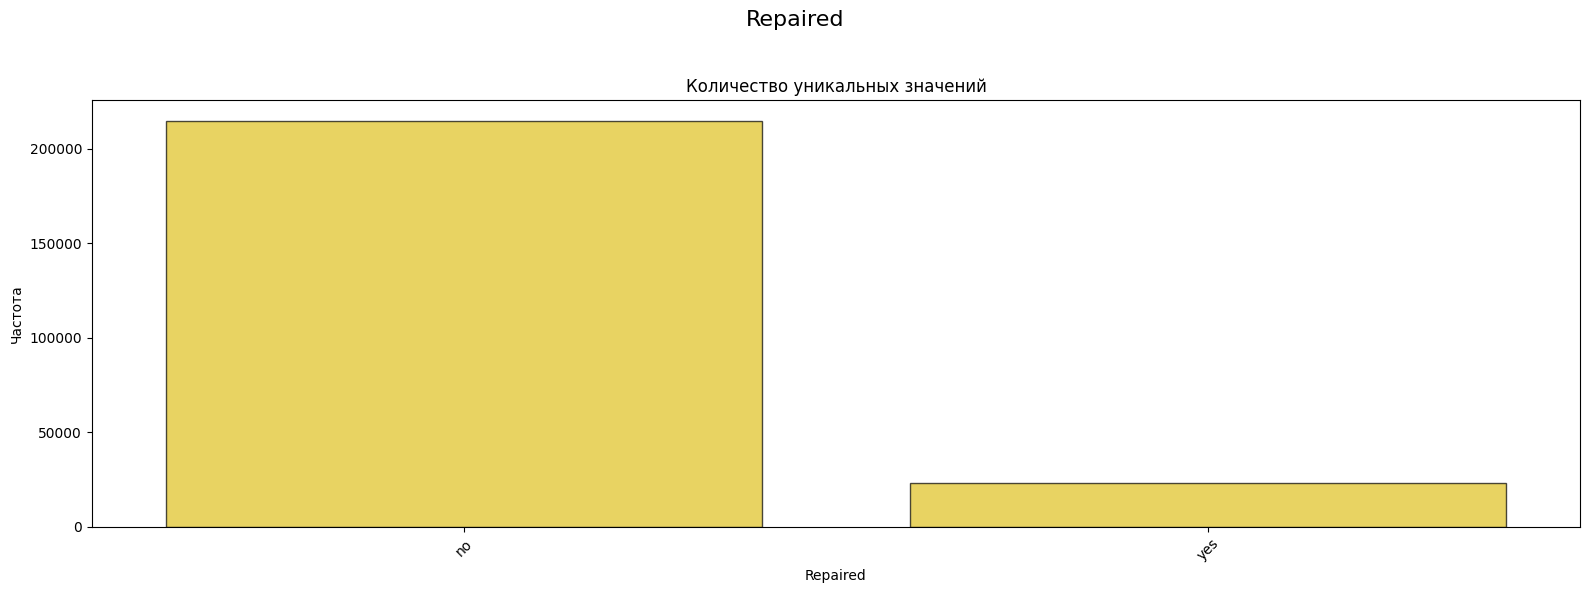

In [45]:
analize_feature('Repaired')

Обычно, если машина в ремонте не была, в объявлении не указывают никакую информацию о ремонте, поэтому заполним пропуски константой.

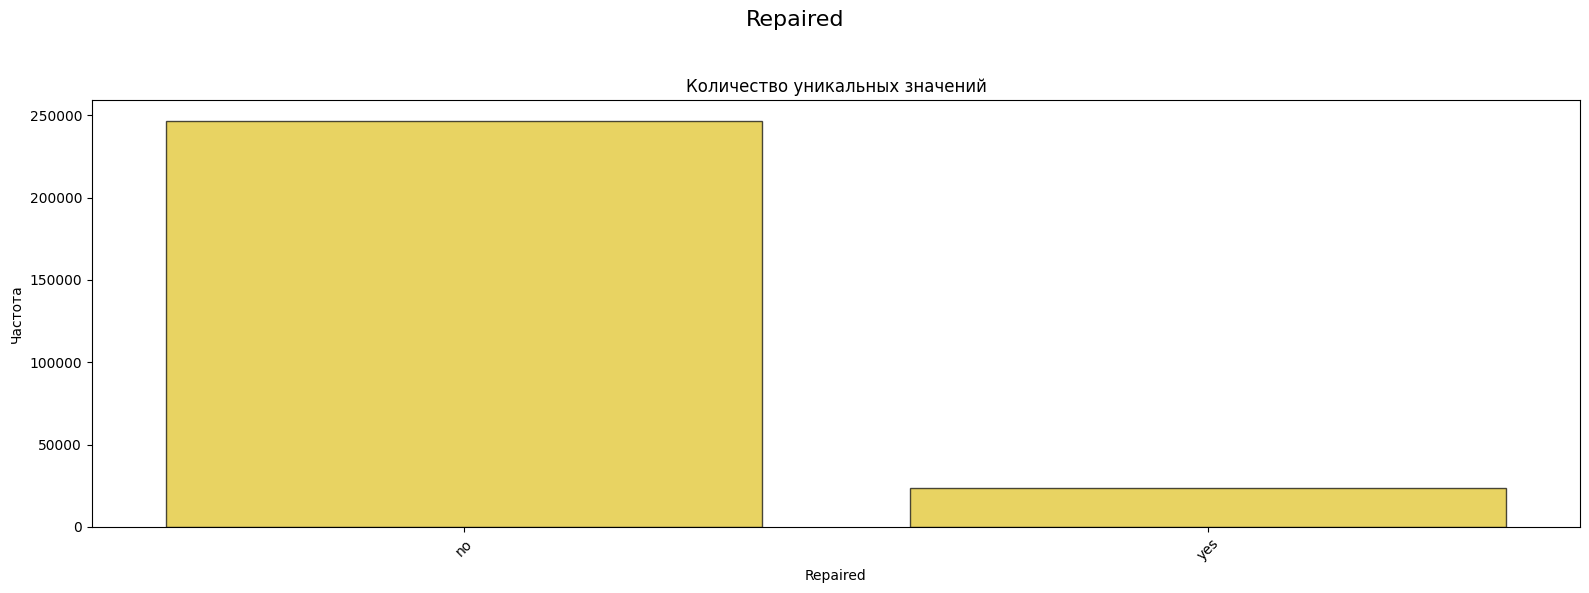

In [46]:
df['Repaired'].fillna('no', inplace=True)

analize_feature('Repaired')

### DateCreated

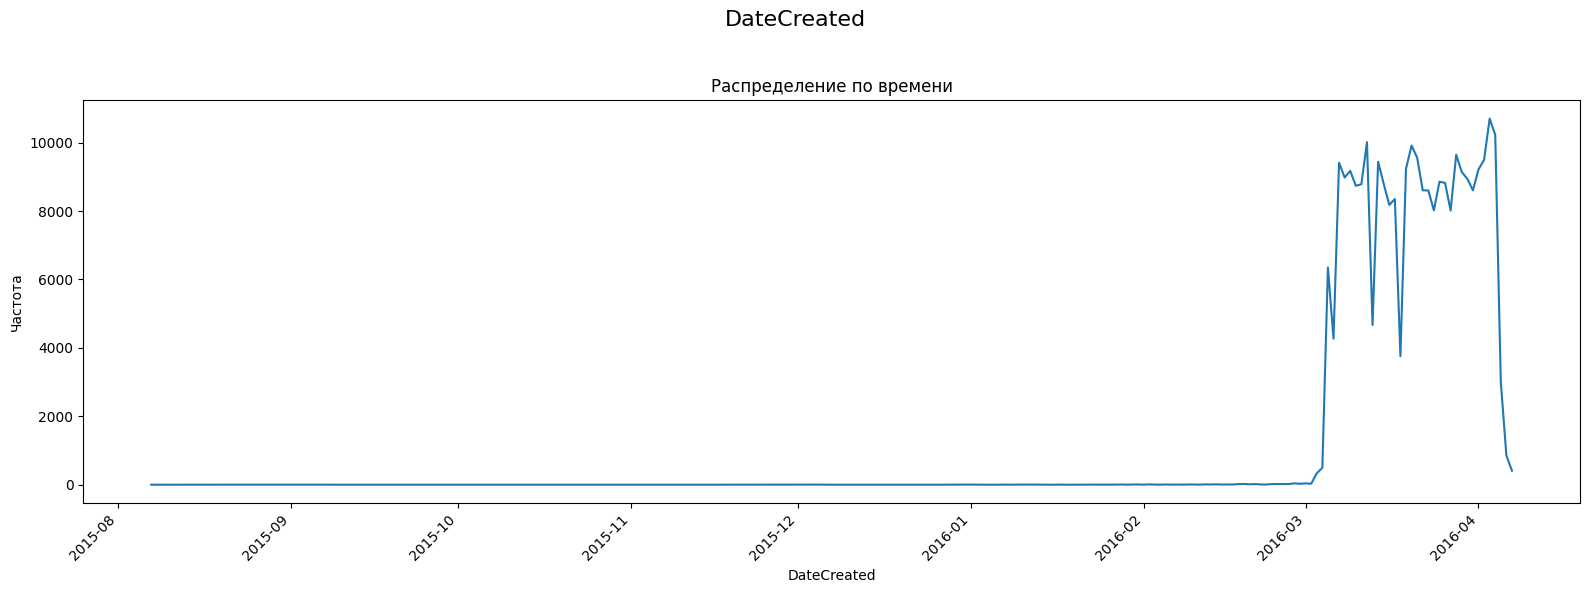

In [47]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
analize_feature('DateCreated')

Извлечем из признака месяц числом, а также ограничим датафрейм только 2016 годом для макимальной актуальности данных.

In [48]:
df = df.query('DateCreated >= "2016-01-01 00:00:00"')

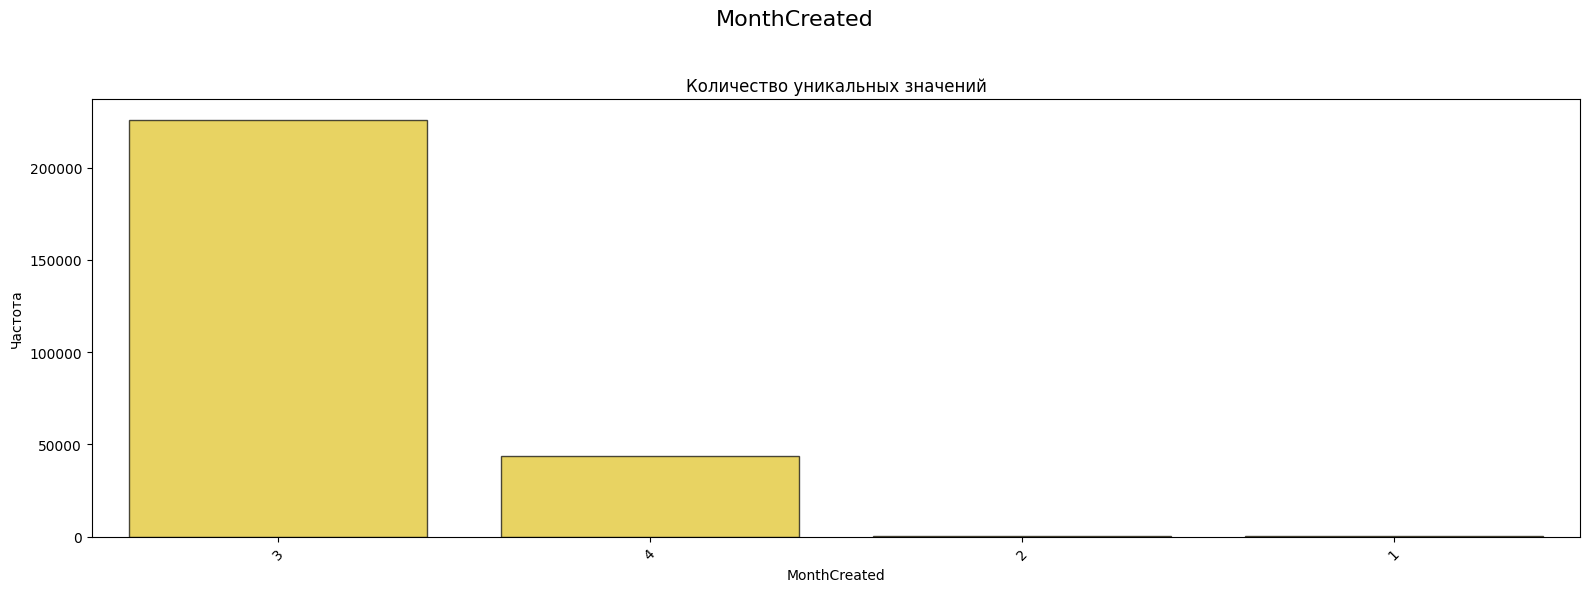

In [49]:
df['MonthCreated'] = df['DateCreated'].dt.month

df = df.drop(columns='DateCreated')

analize_feature('MonthCreated')

### NumberOfPictures

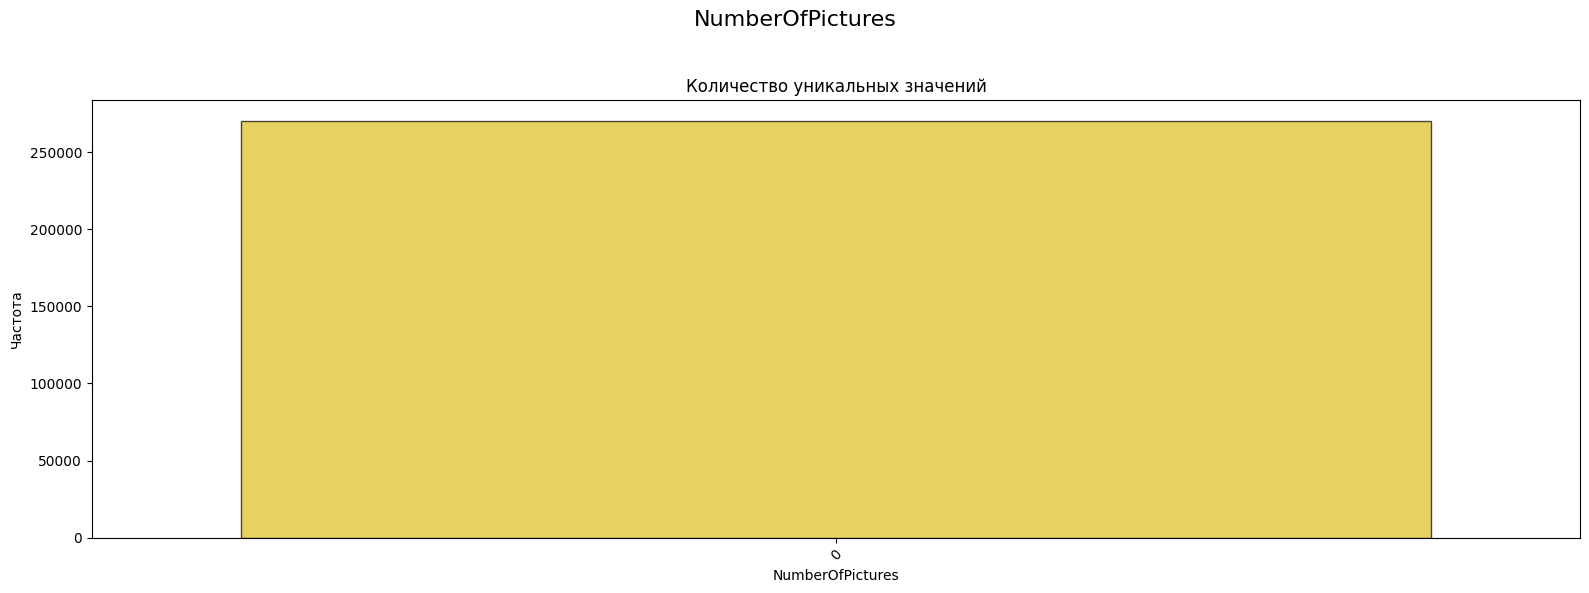

In [50]:
analize_feature('NumberOfPictures')

Поле заполнено константой, его можно удалить.

In [51]:
df = df.drop(columns='NumberOfPictures')

### PostalCode

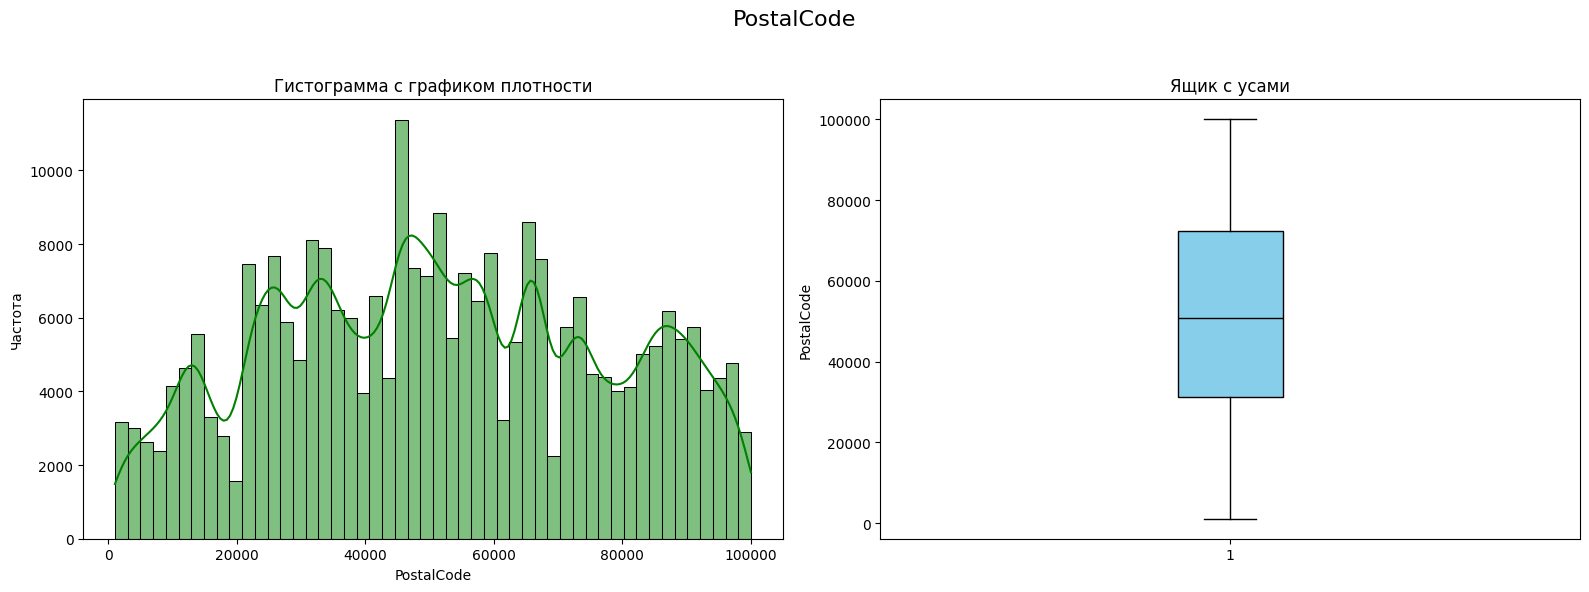

In [52]:
analize_feature('PostalCode')

Визуально здесь все хорошо, вот только 8102 уникальных значения, которые могут быть бесполезны без привязки к конкретным регионам. Попробую их сгруппировать.

In [53]:
df.head()

Попробуем из этих почтовых индексов извлечь страну с помощью библиотеки "geopy".

In [54]:
# файл для промежуточного сохранения
PROGRESS_FILE = "postal_progress.csv"

# подготовка прогресса
if os.path.exists(PROGRESS_FILE):
    progress_df = pd.read_csv(PROGRESS_FILE)
    saved_map = dict(zip(progress_df['PostalCode'], progress_df['Country']))
    processed_codes = set(saved_map.keys())
else:
    saved_map = {}
    processed_codes = set()

# фильтруем коды
postal_codes_all = df['PostalCode'].dropna().astype(str)
postal_codes = [code for code in postal_codes_all.unique() if code not in processed_codes]

# асинхронный сбор
async def fetch_country(session, sem, postal_code):
    url = f"https://nominatim.openstreetmap.org/search?postalcode={postal_code}&format=json"
    async with sem:
        try:
            async with session.get(url) as resp:
                data = await resp.json()
                if data:
                    display_name = data[0].get("display_name", "")
                    country = display_name.split(",")[-1].strip()
                else:
                    country = None
        except Exception:
            country = None

        saved_map[postal_code] = country
        pd.DataFrame(saved_map.items(), columns=["PostalCode", "Country"]).to_csv(PROGRESS_FILE, index=False)
        return postal_code, country

# основной сбор
async def get_all_countries_background():
    sem = asyncio.Semaphore(10)
    async with aiohttp.ClientSession(headers={"User-Agent": "geoapi"}) as session:
        tasks = [fetch_country(session, sem, code) for code in postal_codes]
        await tqdm_asyncio.gather(*tasks)
    print("Геокодинг завершён.")

# запуск в фоне
nest_asyncio.apply()

task = asyncio.create_task(get_all_countries_background())

Код выше выполняется долго, поэтому результат его работы сохранен в файл и будет загружен далее.

In [55]:
# progress_df = pd.read_csv('postal_progress.csv')
# df = pd.merge(df, progress_df, on='PostalCode', how='left')

In [56]:
df.head()

### Country

In [57]:
df = fill_missing_by_mode(df, 'Country', 'PostalCode', 'Brand', 'FuelType', 'Power', 'Gearbox')

In [58]:
df = df.drop(columns='PostalCode')

In [59]:
df['Country'].value_counts()

In [60]:
country_translation = {
    "Deutschland": "Germany",
    "대한민국": "South Korea",
    "Magyarország": "Hungary",
    "Schweiz/Suisse/Svizzera/Svizra": "Switzerland",
    "Österreich": "Austria",
    "Türkiye": "Turkey",
    "België / Belgique / Belgien": "Belgium",
    "México": "Mexico",
    "Lëtzebuerg": "Luxembourg",
    "България": "Bulgaria",
    "Norge": "Norway",
    "España": "Spain",
    "Azərbaycan": "Azerbaijan",
    "Danmark": "Denmark",
    "বাংলাদেশ": "Bangladesh",
    "Italia": "Italy",
    "საქართველო": "Georgia",
    "Україна": "Ukraine",
    "Shqipëria": "Albania",
    "New Zealand / Aotearoa": "New Zealand",
    "Liechtenstein": "Liechtenstein",
    "Հայաստան": "Armenia",
    "Κύπρος - Kıbrıs": "Cyprus",
    "Србија": "Serbia"
}

df['Country'] = df['Country'].replace(country_translation)

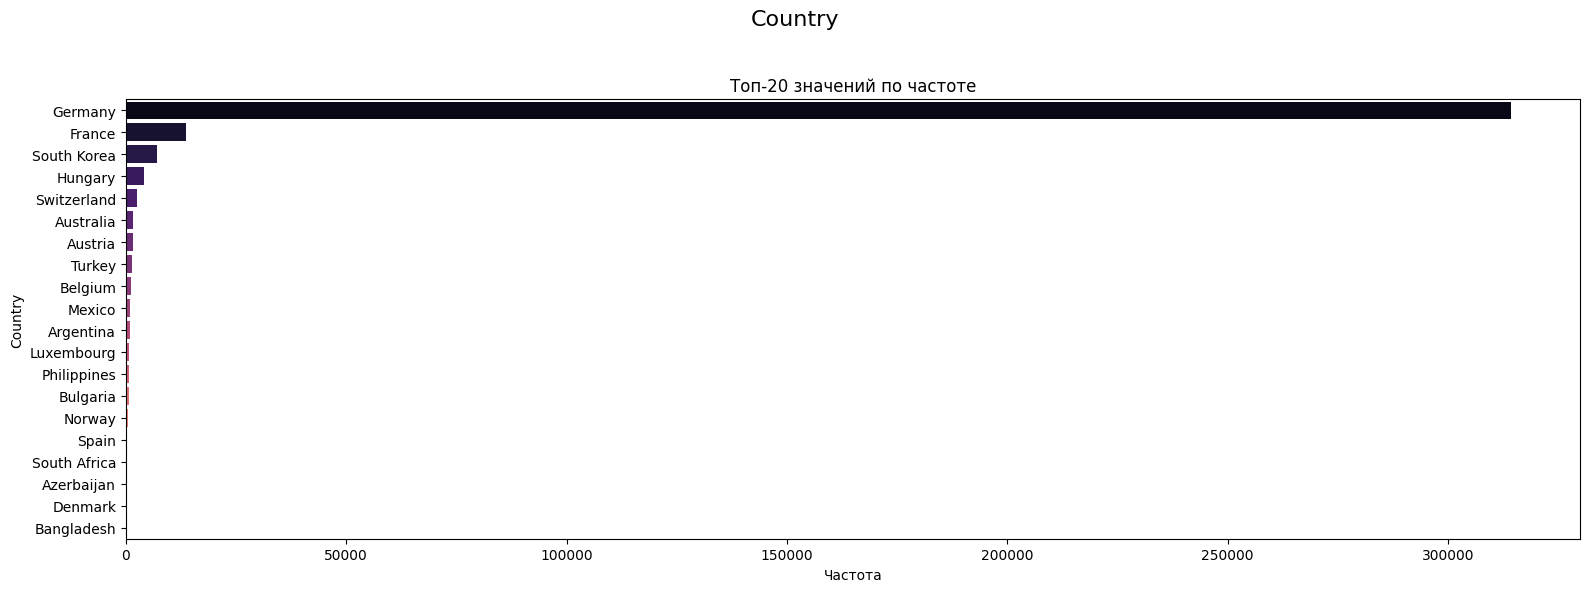

In [61]:
analize_feature('Country')

### LastSeen

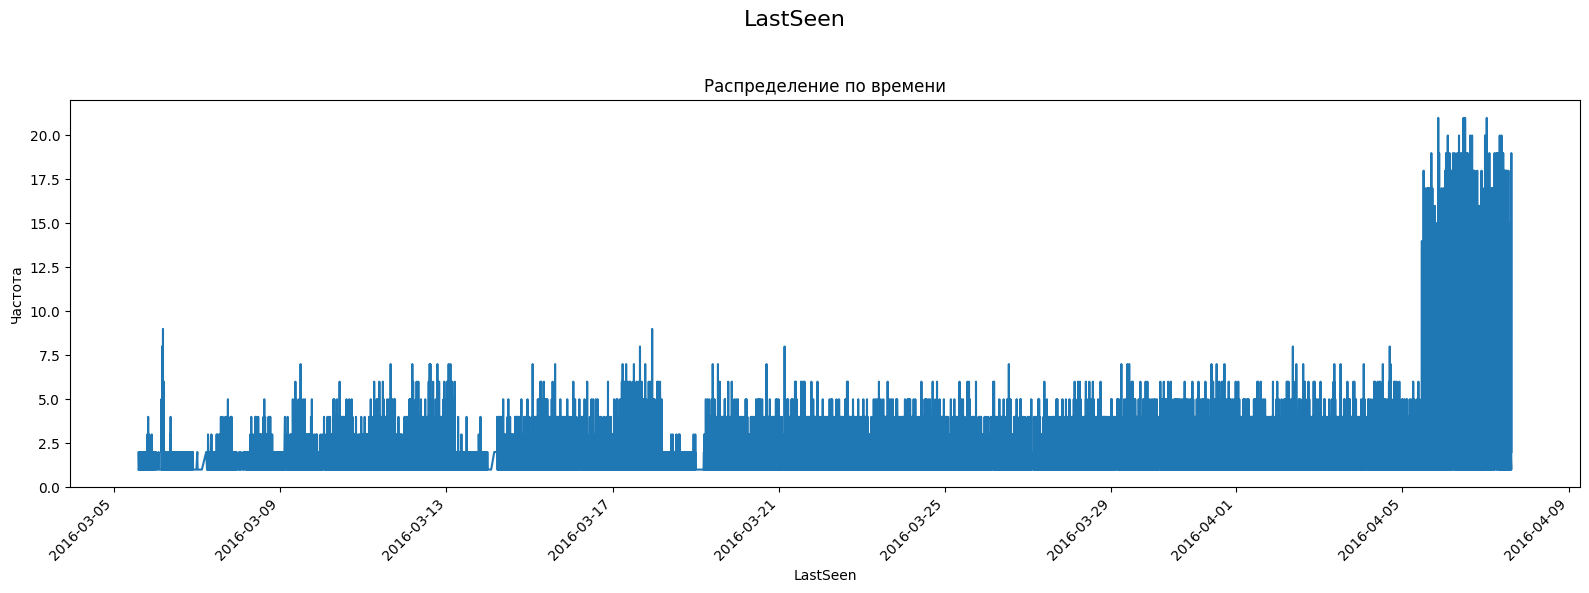

In [62]:
df['LastSeen'] = pd.to_datetime(df['LastSeen'])

df = df.query('LastSeen >= "2016-01-01 00:00:00"')

analize_feature('LastSeen')

Этот признак может показывать актуальность цены. Я уже отсортировал данные, оставив только 2016 год, но значения целиком помочь не смогут, так как их 142 тысячи уникальных. Выделим отсюда месяц.

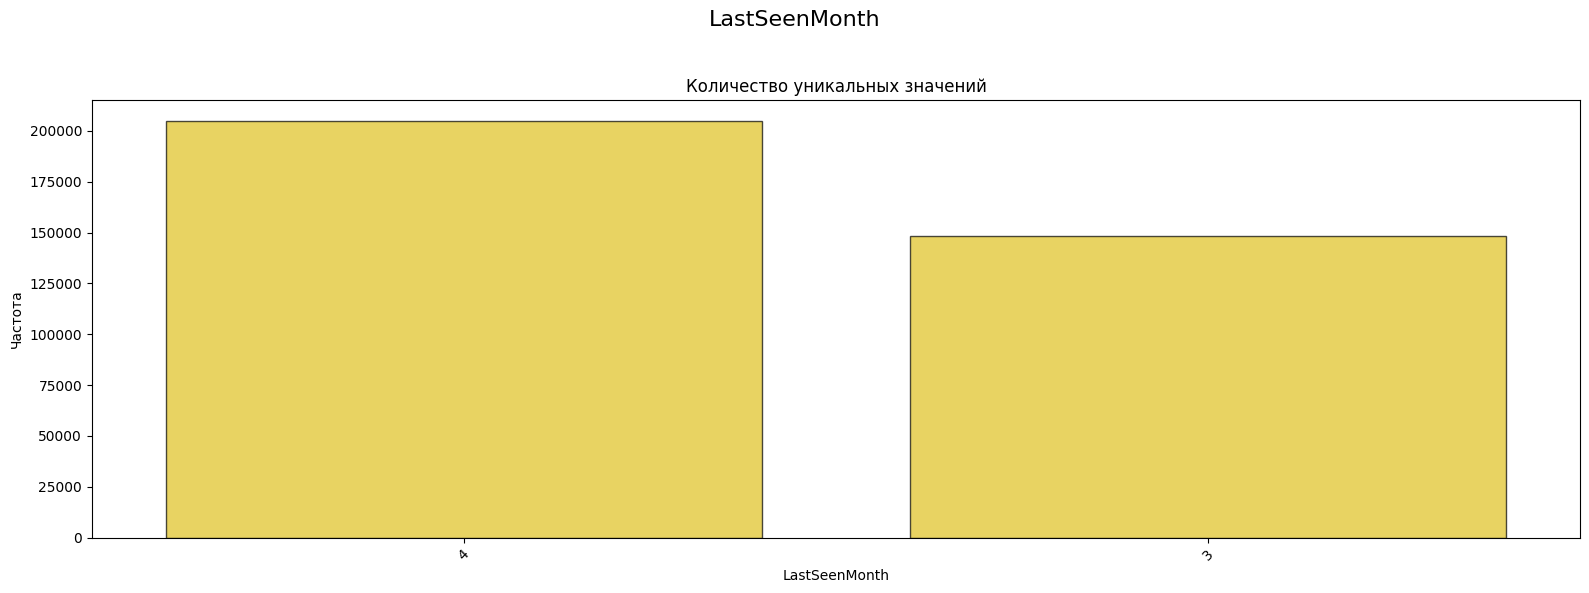

In [63]:
df['LastSeenMonth'] = df['LastSeen'].dt.month

df = df.drop(columns='LastSeen')

analize_feature('LastSeenMonth')

### Вывод по предобработке и исследовательскому анализу

1. **DateCrawled**: Признак DateCrawled был удалён, так как имеет слишком узкий временной интервал, почти все значения уникальны и не связаны с характеристиками автомобиля.

2. **Price**: Удалены записи с ценой от 0 до 300 евро (около 26 тысяч строк). После очистки цены стали в пределах разумного диапазона для поддержанных автомобилей. Рекомендуется учесть влияние дорогих автомобилей (с ценой выше 15,000 евро) на модели.

3. **VehicleType**: Пропуски были заполнены модой, используя комбинации признаков `Brand` и `Model`. Это позволило заполнить 25 тысяч пропусков, остальные строки были удалены. Столбец теперь полностью заполнен.

4. **RegistrationYear**: Удалены записи с регистрационными годами вне диапазона от 1965 до 2016 года (значения 1000 и 9999). После очистки столбец стал значимым для анализа.

5. **Gearbox**: Пропуски заполнены наиболее частым значением (мода), что устранило пропуски и привело к двум возможным типам коробки передач: ручная и автоматическая.

6. **Power**: После удаления экстремальных значений (мощность от 0 до 20000 л/с) диапазон мощностей стал более логичным (45 л/с до 400 л/с), что уменьшило количество строк на 30 тысяч.

7. **Model**: Пропуски заполнены модой на основе других признаков (марка, тип топлива, мощность). Некоторые строки изменены, а некоторые модели нормализованы (например, "range" вместо "range_"). Уникальная строка со значением "rangerover" была удалены.

8. **Kilometer**: Все значения в столбце логичны, диапазон километража варьируется от 5000 до 150000 км, что правдоподобно для поддержанных автомобилей.

9. **RegistrationMonth**: Строки с значением месяца == 0 были удалены. Остальные значения соответствуют диапазону от 1 до 12.

10. **FuelType**: Пропуски заполнены модой на основе других признаков (марка, модель, мощность). Редкие типы топлива, такие как электрическое, пока что оставлены с минимальными значениями.

11. **Brand**: Столбец не содержит неявных дубликатов. Включает 40 уникальных значений, что указывает на корректность данных.

12. **Repaired**: Пропуски заполнены константой "no", так как машины без ремонта чаще всего не указываются как такие. Столбец теперь заполнен корректно.

13. **DateCreated**: Признак был использован для выделения месяца. После преобразования месяца, основной объем данных был создан в марте, с небольшим количеством записей в апреле.

14. **MonthCreated**: Месяц создания записей ограничен только 2016 годом. Основная часть записей создана в марте, что соответствует 75% и 50% значений.

15. **NumberOfPictures**: Признак заполнен константой (0), был удалён.

16. **PostalCode**: Признак содержит 8102 уникальных значений. Без привязки к регионам этот признак не полезен, поэтому использовался геокодинг для группировки почтовых кодов по странам.

17. **CountryByPostalCode**: С помощью геокодинга для каждого почтового индекса была извлечена страна, что улучшило понимание данных и добавило географическую привязку.

18. **LastSeen**: Признак показывает последний момент, когда объект был доступен на платформе. Месяц был извлечен, и данные показывают, что большинство объектов были видны в марте и апреле 2016 года. Этот признак может быть полезен для оценки актуальности цен.

## Корреляционный анализ

In [64]:
df.dtypes

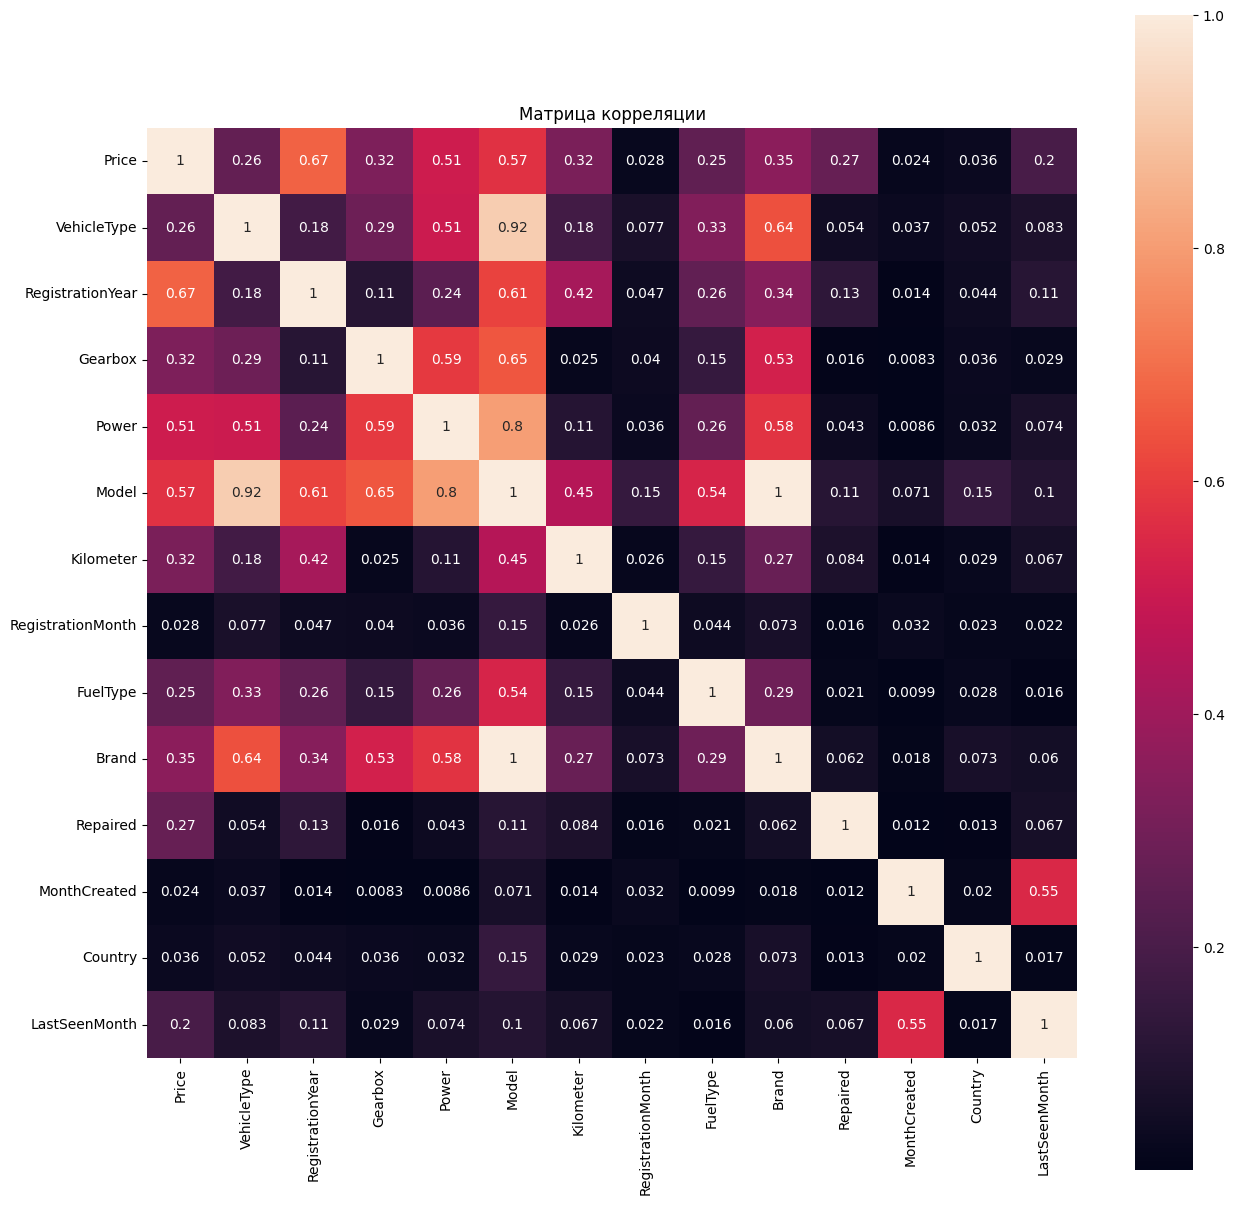

In [65]:
interval_cols = ['Price', 
                 'RegistrationYear', 
                 'Power', 
                 'Kilometer', 
                 ]

corr_matrix = df.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, square=True)
plt.title('Матрица корреляции')
plt.xticks(rotation=90)
plt.yticks()
plt.show()

Brand и Model коррелируют друг с другом на 1, поэтому любой из этих признаков можно удалить не потеряв в качестве будущей модели.

In [66]:
df.drop(columns='Brand', inplace=True)

### Вывод по корреляционному анализу

Корреляционный анализ позволил выявить следующие закономерности:

1. **Целевая переменная `Price`**:
   - Сильно коррелирует только сама с собой.
   - Имеет **умеренную положительную корреляцию** с признаками: `RegistrationYear`, `Gearbox`, `Power`, `Model`, `Kilometer`, `Brand`. Эти переменные потенциально полезны для построения модели.

2. **Технические характеристики (`Power`, `Gearbox`, `Kilometer`)**:
   - Наиболее сильно взаимосвязаны между собой и с ценой. Особенно `Power` и `Model` — высокая корреляция с `Price`, что делает их важными признаками.
   - `Kilometer` (пробег) показывает умеренную корреляцию с ценой — это логично, так как пробег влияет на стоимость автомобиля.

3. **Категориальные признаки (`Brand`, `Model`, `VehicleType`)**:
   - `Model` имеет сильную связь с `Brand`, `Power` и `VehicleType`, а также умеренно коррелирует с `Price`.
   - `VehicleType` и `FuelType` слабо или умеренно связаны с целевой переменной, но могут быть полезны в сочетании с другими признаками.

4. **Временные признаки (`RegistrationYear`, `MonthCreated`, `LastSeenMonth`)**:
   - `RegistrationYear` — умеренная корреляция с `Price`, полезен для оценки возраста машины.
   - `MonthCreated` и `LastSeenMonth` слабо связаны с целевой переменной и, вероятно, не внесут значимого вклада в модель.

5. **Слабо информативные признаки**:
   - `PostalCode`, `Repaired`, `RegistrationMonth`, `DateCrawled`, `NumberOfPictures` не имеют корреляции с ценой и, вероятно, могут быть удалены на этапе предобработки.

Матрица корреляции показала, что признаки `Power`, `Model`, `Brand`, `Kilometer`, `Gearbox` и `RegistrationYear` имеют наибольшее значение для предсказания цены автомобиля. Некоторые переменные (временные и географические) не показывают значимой связи с целевой переменной и могут быть исключены из модели, чтобы сократить размерность и улучшить производительность.

In [67]:
df.drop(columns=['MonthCreated', 'LastSeenMonth'], inplace=True)

## Моделирование

### Сплит

In [68]:
X = df.drop('Price', axis=1)
y = df['Price']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

### Пайплйны

In [70]:
cat_cols_less_50 = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Country']
cat_cols_more_50 = ['Model']
num_cols = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

In [71]:
# пайплайн для числовых данных
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [72]:
# пайплайн для категориальных данных
cat_pipeline_less_50 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

In [73]:
# пайплайн для категориальных данных, где признаков больше 50
cat_pipeline_more_50 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

In [74]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat_less_50', cat_pipeline_less_50, cat_cols_less_50),
        ('cat_more_50', cat_pipeline_more_50, cat_cols_more_50)
    ]
)

In [75]:
# пайплайн для моделей
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [76]:
lr_params = [
    {
        'model': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

lgbm_params = [
    {
        'model': [LGBMRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': range(10, 200, 10),
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [-1, 5, 10, 15],
        'preprocessor__num': ['passthrough']
    }
]

catboost_params = [
    {
        'model': [CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)],
        'model__iterations': range(10, 200, 10),
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__depth': range(1, 10),
        'preprocessor__num': ['passthrough']
    }
]

### Обучение моделей

In [77]:
# Создадим собственную метрику RMSE для оценки
def rmse_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return -np.sqrt(mean_squared_error(y, y_pred))

In [78]:
import time

In [79]:
def find_model_random(pipeline, params, n_iter=10):
    randomized_search = RandomizedSearchCV(
        pipeline,
        param_distributions=params,
        n_iter=n_iter,
        scoring=rmse_scorer,
        refit=True,
        cv=3,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )

    # обучение модели
    randomized_search.fit(X_train, y_train)
    
    # лучшая модель и метрика
    best_model = randomized_search.best_estimator_
    cv_rmse = -randomized_search.best_score_
    best_params = randomized_search.best_params_
    
    # время обучения и предсказания
    mean_fit_time = randomized_search.cv_results_['mean_fit_time'][randomized_search.best_index_]
    mean_score_time = randomized_search.cv_results_['mean_score_time'][randomized_search.best_index_]
    
    print(f'Кросс-валидационная RMSE: {cv_rmse:.2f}')
    print(f'Среднее время обучения: {mean_fit_time:.2f} сек')
    print(f'Среднее время предсказания: {mean_score_time:.2f} сек')
    print('Лучшие параметры:', best_params)
    
    return randomized_search, cv_rmse, mean_fit_time, mean_score_time

results = []

In [80]:
# удалим все переменные, кроме тех, что нужны для обучения моделей

# нужные имена переменных
required_vars = {
    'df', 'X', 'y', 'X_train', 'X_test', 'y_train', 'y_test',
    'cat_cols_less_50', 'cat_cols_more_50', 'num_cols',
    'num_pipeline', 'cat_pipeline_less_50', 'cat_pipeline_more_50',
    'preprocessor', 'pipeline',
    'lr_params', 'lgbm_params', 'catboost_params',
    'rmse_scorer', 'find_model_random',
    'RANDOM_STATE', 'TEST_SIZE',
    'LinearRegression', 'LGBMRegressor', 'CatBoostRegressor',
    'Pipeline', 'SimpleImputer', 'StandardScaler', 'MinMaxScaler',
    'OneHotEncoder', 'ColumnTransformer', 'RandomizedSearchCV',
    'mean_squared_error', 'np', 'train_test_split', 'time', 'plt'
}

# удаляем все, что не входит в список нужных переменных
for name in list(globals().keys()):
    if not name.startswith("_") and name not in required_vars:
        del globals()[name]

In [81]:
results = []

In [82]:
print("Обучение LinearRegression...")
lr_search, lr_cv_rmse, lr_fit_time, lr_score_time = find_model_random(pipeline, 
                                                                      lr_params, 
                                                                      n_iter=3)
results.append({
    'Model': 'LinearRegression',
    'CV RMSE': lr_cv_rmse,
    'Fit Time (s)': lr_fit_time,
    'Score Time (s)': lr_score_time
})

In [83]:
print("\nОбучение LGBMRegressor...")
lgbm_search, lgbm_cv_rmse, lgbm_fit_time, lgbm_score_time = find_model_random(pipeline,
                                                                              lgbm_params, 
                                                                              n_iter=5)
results.append({
    'Model': 'LGBMRegressor',
    'CV RMSE': lgbm_cv_rmse,
    'Fit Time (s)': lgbm_fit_time,
    'Score Time (s)': lgbm_score_time
})

In [84]:
print("\nОбучение CatBoostRegressor...")
catboost_search, catboost_cv_rmse, catboost_fit_time, catboost_score_time = find_model_random(pipeline, 
                                                                                              catboost_params, 
                                                                                              n_iter=5)
results.append({
    'Model': 'CatBoostRegressor',
    'CV RMSE': catboost_cv_rmse,
    'Fit Time (s)': catboost_fit_time,
    'Score Time (s)': catboost_score_time
    
})

In [85]:
# Оценка времени предсказания на тестовом наборе
start_time = time.time()
y_test_pred = lgbm_search.best_estimator_.predict(X_test)
test_score_time = time.time() - start_time
print(f'Время предсказания на тестовом наборе: {test_score_time:.2f} сек')

In [86]:
# вычисляем RMSE на тестовой выборке
lgbm_y_test_pred = lgbm_search.best_estimator_.predict(X_test)
lgbm_test_rmse = np.sqrt(mean_squared_error(y_test, lgbm_y_test_pred))
print(f'RMSE на тестовой выборке у модели LGBM: {lgbm_test_rmse:.2f}')

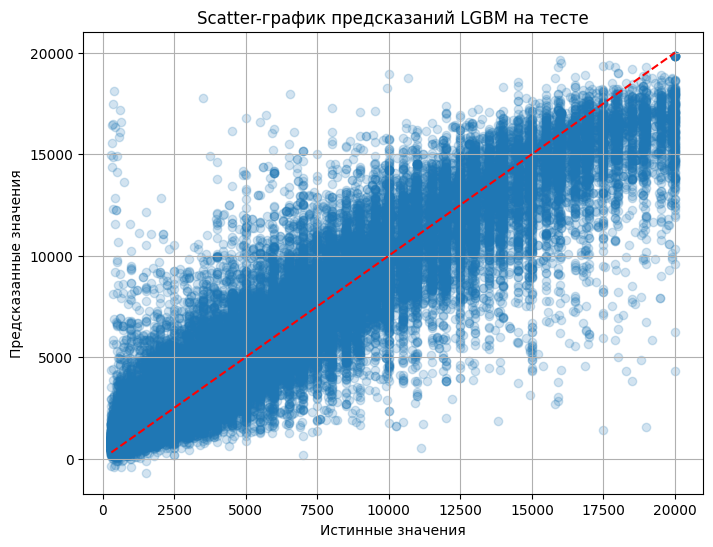

In [87]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Scatter-график предсказаний LGBM на тесте")
plt.grid(True)
plt.show()

### Вывод-анализ по моделированию

**Цели заказчика:**
Заказчику важны следующие критерии при выборе модели:
1. **Качество предсказания** — минимизация ошибки (RMSE);
2. **Время обучения модели** — важно при масштабировании и дообучении;
3. **Время предсказания модели** — критично при работе в проде или в режиме реального времени.

---

**Вывод по моделированию**

**Цель**: выбрать модель, минимизирующую RMSE, с быстрым временем обучения и предсказания для использования в продакшене.

**Качество модели (CV RMSE):**
- **LGBMRegressor** показывает наилучшее качество по кросс-валидации (RMSE ≈ 1645).
- **CatBoostRegressor** отстает по точности, но все еще показывает приемлемые результаты.
- **LinearRegression** сильно проигрывает по качеству.

**Время обучения:**
- **LinearRegression** обучается быстрее всех, но жертвует качеством.
- **LGBMRegressor** — разумный компромисс между точностью и скоростью обучения.
- **CatBoostRegressor** обучается дольше всех.

**Время предсказания:**
- Все модели показывают высокую скорость предсказания.
- **CatBoost** немного быстрее, но **LGBM** тоже достаточно быстр (менее 1 секунды на весь набор).

**Рекомендации:**
- **LGBMRegressor** — лучший выбор:
  - Лучшая точность на кросс-валидации;
  - Быстрое обучение;
  - Высокая скорость предсказания;
  - Отлично подходит для реального использования.

**Тестирование:**
- **RMSE на отложенном тесте для LGBMRegressor: ~1625.92** — подтверждает стабильность модели.
- Визуальный анализ показывает, что модель хорошо справляется с предсказаниями даже на новых данных.

> **Важно:** модели не сравнивались по тестовой метрике при выборе — тест использовался **только для финальной проверки** качества лучшей модели.

**Рекомендация**

**LGBMRegressor** — **наилучший выбор**:
- Обеспечивает **лучшую точность**;
- Обучается **достаточно быстро**;
- Делает предсказания **с высокой скоростью**.

Подходит для задач, где требуется **баланс между точностью и производительностью**.


## Общий вывод на базовое решение

**Этап предобработки данных**

Были проведены следующие ключевые шаги:

- **Удалены нерелевантные и слабо информативные признаки**:
  - `DateCrawled`, `NumberOfPictures`, `PostalCode` — из-за низкой информативности и высокой уникальности.
- **Очистка целевой переменной `Price`**:
  - Удалены автомобили с нереалистичной ценой (0–300 евро).
  - Итоговый диапазон — от 300 до ~15,000 евро.
- **Заполнение пропусков**:
  - `VehicleType`, `Gearbox`, `FuelType`, `Model`, `Repaired` — заполнены модой и по группам Brand/Model.
- **Очистка выбросов**:
  - `Power`: удалены значения > 1000 л.с.
  - `RegistrationYear`: оставлены года от 1965 до 2016.
  - `RegistrationMonth`: удалены строки с 0.
- **Создание новых признаков**:
  - `MonthCreated` и `LastSeenMonth` на основе временных признаков.
  - `CountryByPostalCode` через геокодинг.

**Итог:** данные приведены к чистому, логичному виду с минимальными пропусками и выбросами.

---

**Корреляционный анализ**

- **Наиболее информативные признаки для предсказания `Price`**:
  - `Power`, `Model`, `Brand`, `Kilometer`, `Gearbox`, `RegistrationYear`.

- **Слабо коррелирующие признаки (могут быть удалены)**:
  - `PostalCode`, `Repaired`, `RegistrationMonth`, `DateCrawled`, `NumberOfPictures`, `MonthCreated`, `LastSeenMonth`.

- **Категориальные переменные**:
  - `Model` тесно связана с `Brand`, `VehicleType`, `Power` — может выступать как мультипризнак.

---

**Сравнение моделей**

| Модель               | CV RMSE      | RMSE (Test) | Время обучения | Время предсказания |
|----------------------|--------------|-------------|----------------|---------------------|
| **LGBMRegressor**     | **1644.66**  | **1625.92** | ~8.8 сек       | ~0.74 сек           |
| **CatBoostRegressor** | 2052.52      |---    | ~10.4 сек      | ~0.85 сек           |
| **LinearRegression**  | 2591.43      |---    | ~5.4 сек       | ~0.4 сек            |

---

**Анализ моделей**

- **Качество предсказания**:
  - **LGBM** — наименьший RMSE, стабильная точность на кросс-валидации и тесте.
  - **CatBoost** немного уступает, но также приемлем.
  - **Linear Regression** заметно хуже по всем метрикам.

- **Время обучения**:
  - **Linear Regression** — самый быстрый, но жертвует точностью.
  - **LGBM** — оптимальный баланс.
  - **CatBoost** обучается дольше всех.

- **Скорость предсказания**:
  - Все модели быстрые.
  - **CatBoost** чуть медленнее остальных, но разница минимальна.

---

**Рекомендация**

**LGBMRegressor** — **лучший выбор** с учетом требований к точности, скорости и стабильности:

- Обеспечивает **наивысшую точность предсказаний**;
- **Обучается быстро**;
- Делает **предсказания с минимальной задержкой**, подходит для продакшна.

**Итог:** модель LGBMRegressor рекомендована для финального решения задачи оценки стоимости автомобилей на вторичном рынке.
